In [8]:
%matplotlib inline
import jax.numpy as jnp
from jax import random
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as snb

import os
import sys
sys.path.append(os.path.abspath('..'))
from exercise6 import compute_err
from exercise6 import eval_density_grid
from exercise6 import load_MNIST_subset
from exercise6 import plot_with_uncertainty
from exercise6 import add_colorbar
from exercise6 import StationaryIsotropicKernel
from exercise6 import squared_exponential
from exercise6 import matern12
from exercise6 import matern32
from exercise6 import NeuralNetworkMAP
from exercise6 import generate_samples

# from autograd import grad, 
from scipy.optimize import minimize
from scipy.stats import norm
from scipy.stats import binom as binom_dist

from jax import config
config.update("jax_enable_x64", True)

snb.set_style('darkgrid')
snb.set_theme(font_scale=1.1)


# 02477 Bayesian Machine Learning: Gaussian processes classification

The purpose of this exercise is to
- get familiar with Bayesian modelling using non-Gaussian likelihoods, we will study the Bernoulli likelihood in particular.
- study Gaussian processes for binary classification via the Laplace approximation
- dive deeper into Gaussian processes 

**Content**

- Part 1: Theory for binary classification using Gaussian process
- Part 2: Implementing the Laplace approximation (Step 1 of 3)
- Part 3: Implementing the posterior distribution of $p(f^*|\mathbf{y}, \mathbf{x}^*)$ (step 2 of 3)
- Part 4: Compute the posterior predictive distribution of the label $y^*$ for the input point $\mathbf{x}^*$, i.e. to compute $p(y^*|\mathbf{y}, \mathbf{x}^*)$. (Step 3 of 3)
- Part 5: Gaussian process classification for 2D data set


**Note**: In this exercise, we will use the code from last week for the squared exponential kernel etc. We will also make use of a set of auxiliary functions, which are less important for the learning objectives of today and therefore, they can found in the module `exercise6.py`.

**Note**: The exercise contains several **discussion questions**, which are questions, where are supposed to actively experiment with the code and/or reason with the equations to arrive at the relevant conclusions. This also means that we won't provide a specific solution for this task. However, you are more than welcome to check your understanding and your conclusions with the TAs. Instead of proving the full description for every discussion question, we simply tag it with: [**Discussion question**] after the question.

# A toy dataset

First, we will implement and test everything on a simple 1D toy dataset. The dataset is generated using the following model:

$$\begin{align*}
y_n|x_n &\sim \text{Ber}(\sigma(f(x_n)))\\
f(x_n) &= 5 \sin\left(\frac{3}{4}x\right)\\
x_n &\sim \mathcal{N}(0, 2.5),
\end{align*}$$

Hence, the true data generating process is $p(y=1|x) = \sigma(5\sin(\frac{3}{4} x))$, where $\sigma(x) = \frac{1}{1 + e^{-x}}$ is the logistic sigmoid function.

Shape of X: (50, 1)


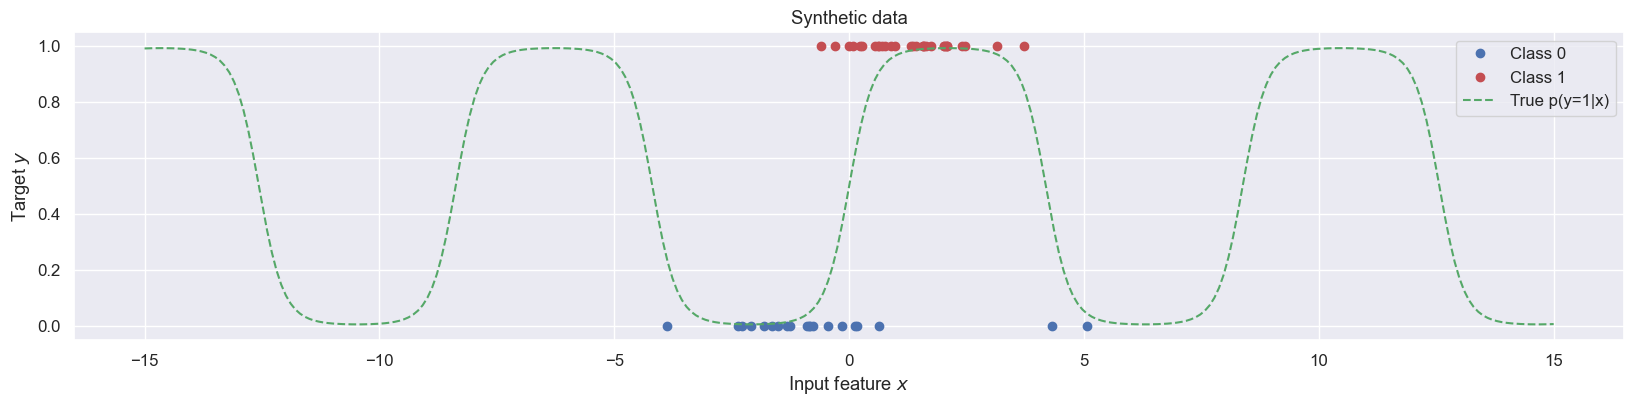

In [9]:
# Import necessary libraries (make sure you have imported these already)
# Fix the random seed for reproducibility of results
seed = 2
key = random.PRNGKey(seed)  # Initialize a pseudo-random number generator key using JAX
key_X, key_y = random.split(key)  # Split the key into two separate keys for independent random operations

# Define the sigmoid activation function to map real values to probabilities between 0 and 1
sigmoid = lambda x: 1. / (1 + jnp.exp(-x))

# Define the true underlying function f(x) used to generate probabilities
# This represents the log-odds or "logits" of a positive classification (y=1)
# This specific function is chosen arbitrarily to create nonlinear behavior in the generated data
f = lambda x: 5 * jnp.sin(0.75 * x)

# Generate synthetic data
N = 50  # Number of data points

# Sample N random input features X from a normal distribution scaled by sqrt(2.5)
# Sorting X ensures a clear visual representation when plotting
X = jnp.sort(jnp.sqrt(2.5) * random.normal(key_X, shape=(N,)))[:, None]  # [:, None] adds an extra dimension for compatibility, the dimenions of X is N x 1
print("Shape of X:", X.shape)


# Generate corresponding binary labels y for each input feature based on probability sigmoid(f(X))
# Each y value is sampled independently from a Bernoulli distribution (binomial with n=1)
y = random.binomial(key_y, n=1, p=sigmoid(f(X)))
# print(y)

# Define a dense range of points Xstar used later for predictions and smooth visualization of the true underlying function
Xstar = jnp.linspace(-15, 15, 300)[:, None]

# Define a function to plot the generated synthetic data clearly distinguishing two classes (y=0 and y=1)
def plot_data(ax, X, y, title="Synthetic data", plot_true=False):
    # Plot class 0 points (blue circles)
    ax.plot(X[y == 0], y[y == 0], 'bo', label='Class 0')

    # Plot class 1 points (red circles)
    ax.plot(X[y == 1], y[y == 1], 'ro', label='Class 1')

    # Optionally plot the true underlying probability function (green dashed line)
    if plot_true:
        ax.plot(Xstar, sigmoid(f(Xstar)), 'g--', label='True p(y=1|x)')

    # Set plot labels and title for clarity
    ax.set(xlabel='Input feature $x$', ylabel='Target $y$', title=title)
    ax.legend()  # Display a legend clearly distinguishing different plotted elements

# Create the plot with a specified figure size for visibility
fig, ax = plt.subplots(1, 1, figsize=(20, 4))
plot_data(ax, X, y, plot_true=True)  # Call the plotting function with the option to visualize the true underlying function

plt.show()  # Display the plot

# Part 1:  Theory for binary classification using Gaussian process

We will study Gaussian processes for binary classification using the following model

$$\begin{align*}
y|f(\mathbf{x}) &\sim \text{Ber}[\sigma(f(\mathbf{x}))]\\
f(\mathbf{x}) &\sim \mathcal{GP}(0, k(\mathbf{x}, \mathbf{x}')),
\end{align*}$$

where $k(\mathbf{x}, \mathbf{x}')$ is the covariance function and $\sigma: \mathbb{R} \rightarrow (0, 1)$ is a suitable inverse link function. Here we will use the logistic sigmoid function. The purpose of the function $\sigma: \mathbb{R} \rightarrow (0, 1)$ is to "squeeze" the values of $y(\mathbf{x})$ from the entire real line to the unit interval such that we can interpret $\sigma(f(\mathbf{x})) \in \left(0, 1\right)$ as a probability for all $\mathbf{x}$.

Our goal is to compute the *posterior predictive distribution* $p(y^* = 1|\mathbf{y}, \mathbf{x}^*)$ for the class label $y^*$ associated with a new input point $\mathbf{x}^* \in \mathbb{R}^D$ given a dataset $\mathcal{D} = \left\lbrace \mathbf{x}_n, y_n \right\rbrace_{n=1}^N$ for $\mathbf{x} \in \mathbb{R}^D$ and $y_n \in \left\lbrace 0, 1 \right\rbrace$. Let $\mathbf{y} \in \left\lbrace 0, 1 \right\rbrace^N$ be the vector of binary observations and let $\mathbf{f} = \begin{bmatrix}f(\mathbf{x}_1) & f(\mathbf{x}_2) & \dots & f(\mathbf{x}_N) \end{bmatrix} \in \mathbb{R}^N$ be the corresponding vector of latent function values for each sample in the training set, then the joint model of the observations $\mathbf{y}$ and the latent function values $\mathbf{f}$ becomes

$$\begin{align*}
p(\mathbf{y}, \mathbf{f}) = p(\mathbf{y}|\mathbf{f})p(\mathbf{f}) = \prod_{n=1}^N \text{Ber}(y_n|\sigma(f_n)) \, \mathcal{N}(\mathbf{f}|\mathbf{0}, \mathbf{K}),
\end{align*}
$$

where we have assumed the observations to be conditionally independent given $\mathbf{f}$, and $\mathbf{K} \in \mathbf{R}^{N \times N}$ is the prior covariance matrix of $\mathbf{f}$, i.e. $\mathbf{K}_{nm} = k(\mathbf{x}_n, \mathbf{x}_m)$.

#### A 3-step approach for computing the posterior predictive distribution for $y^*$

Just like for the Bayesian logistic regression model, exact analytical Bayesian inference is intractable for this model, and therefore, we will resort to the Laplace approximation. Making predictions for a Gaussian process classification model using the Laplace approximation typically requires threes steps:

- Step 1: Aproximating the posterior distribution $p(\mathbf{f}|\mathbf{y})$

- Step 2: Computing the posterior distribution of the latent function evaluated at a new point $\mathbf{x}^*$, i.e computing $p(f^*|\mathbf{y}, \mathbf{x}^*)$ where $f^* = f(\mathbf{x}^*)$.

- Step 3: Computing the posterior predictive distribution of the label $y^*$ for the input point $\mathbf{x}^*$, i.e. computing $p(y^*|\mathbf{y}, \mathbf{x}^*)$.

**Note**: For the regression models with Gaussian likelihoods, there is often a lot of confusion about the difference between $f^*$ and $y^*$. Part of this confusion is often caused by the fact that for regression $f^*$ and $y^*$ typically belong to the same mathematical space, e.g. $f^*, y^* \in \mathbf{R}$ and often $f^*$ can be interpreted as a *denoised* version of $y^*$. However, for binary classification models, the two quantities belong to different spaces, i.e. $f^* \in \mathbb{R}$ and $y^* \in \left\lbrace 0, 1 \right\rbrace$ and here it might be more clear that $f(\mathbf{x})$ simply is a latent function, which we introduce in order to model the distribution $\text{Ber}(y^*|\sigma(f^*))$.


# Part 2:  Implementing the Laplace approximation (Step 1 of 3)

Our goal is now to implement the Laplace approximation for $p(\mathbf{f}|\mathbf{y})$ such that

$$\begin{align*}
p(\mathbf{f}|\mathbf{y}) = \frac{p(\mathbf{y}|\mathbf{f})p(\mathbf{f})}{p(\mathbf{y})}\approx q(\mathbf{f}) = \mathcal{N}(\mathbf{f}|\mathbf{m}, \mathbf{S}),
\end{align*}$$

where $\mathbf{m} = \mathbf{f}_{\text{MAP}}$ is the MAP estimator for $\mathbf{f}$ and $\mathbf{S}$ is the negative inverse Hessian. As usual, we set-up the log joint distribution

$$\begin{align*}
\log p(\mathbf{y}, \mathbf{f}) &= \log p(\mathbf{y}|\mathbf{f}) + \log p(\mathbf{f})
%
= \sum_{n=1}^N \log  p(y_n|f_n) - \frac{N}{2}\log (2\pi) - \frac12 | \mathbf{K}| - \frac12 \mathbf{f}^T\mathbf{K}^{-1} \mathbf{f} 
\end{align*}$$

where the gradient and the Hessian are given by

$$\begin{align*}
\nabla_{\mathbf{f}} \log p(\mathbf{y}, \mathbf{f}) &= \sum_{n=1}^N \nabla_{\mathbf{f}}\log  p(y_n|f_n) - \frac12 \nabla_{\mathbf{f}}\mathbf{f}^T\mathbf{K}^{-1} \mathbf{f} = \mathbf{g} - \mathbf{K}^{-1} \mathbf{f},\\
%
\nabla_{\mathbf{f}}^2 \log p(\mathbf{y}, \mathbf{f}) &= \sum_{n=1}^N  \nabla_{\mathbf{f}}^2 \log  p(y_n|f_n) - \frac12 \nabla_{\mathbf{f}}^2\mathbf{f}^T\mathbf{K}^{-1} \mathbf{f}
=\sum_{n=1}^N  \nabla_{\mathbf{f}}^2 \log  p(y_n|f_n) - \mathbf{K}^{-1} 
=-\Lambda - \mathbf{K}^{-1},
\end{align*}$$

where $\mathbf{g} \in \mathbb{R}^N$ with entries given by $g_n = \frac{\partial}{\partial f_n}\log  p(y_n|f_n)$ and $\Lambda \in \mathbb{R}^{N \times N}$ is a diagonal matrix with elements $\Lambda_{nn} = -\nabla_{\mathbf{f}}^2 \log  p(y_n|f_n)$ evaluated at the mode $\hat{\mathbf{f}}_{\text{MAP}} = \argmax_{\mathbf{f}} \log p(\mathbf{y}, \mathbf{f})$. Thus, the mean and covariance matrix for the Laplace approximation $q(\mathbf{f}) = \mathcal{N}(\mathbf{f}|\mathbf{m}, \mathbf{S})$ become 

$$\begin{align*}
\mathbf{m} &= \hat{\mathbf{f}}_{\text{MAP}}\\
\mathbf{S} &= \left(\mathbf{K}^{-1} + \Lambda\right)^{-1}
\end{align*}$$

The expression for the posterior covariance matrix $\mathbf{S}$ involves the inverse of $\mathbf{K}$, which we know can be numerically unstable. To avoid having to compute the inverse of $\mathbf{K}$ explicitly, we will use the [**Woodbury matrix identity**](https://en.wikipedia.org/wiki/Woodbury_matrix_identity) to re-write the expression for the posterior covariance as 
$$\begin{align*}
\mathbf{S} &= \left(\mathbf{K}^{-1} + \Lambda\right)^{-1} = \mathbf{K} - \mathbf{K}\Lambda^{\frac12} (\underbrace{\mathbf{I} + \Lambda^{\frac12}\mathbf{K}\Lambda^{\frac12}}_{\mathbf{B}})^{-1} \Lambda^{\frac12} \mathbf{K}
\end{align*}$$

This might seem like a complicated way of calculating something simple, but the key thing is that the matrix $\mathbf{B} = \mathbf{I} + \Lambda^{\frac12}\mathbf{K}\Lambda^{\frac12}$ is usually well-behaved because its eigenvalues are lowerbounded by $1$, and hence, the linear system $\mathbf{B}^{-1}\Lambda^{\frac12} \mathbf{K}$ can usually be solved without problems, e.g. via Cholesky decompositions.



#### The contributions of the likelihood to the gradient and Hessian

By inspecting the equations above, we see that both the gradient and Hessian contains a contribution from the prior and a contribution from the likelihood. First, will focus on implementing the contributions from the likelihood. We need to compute the first and second order derivatives of the log likelihood $\log p(y_n|f_n) = \log \text{Ber}(y_n|\sigma(f_n))$

**Task 2.1**: Show that first and second order derivative of $\log p(y_n|f_n)$ is given by $\frac{\partial}{\partial f_n}\log p(y_n|f_n) = y_n -\sigma(f_n)$ and $\frac{\partial^2}{\partial f_n^2}\log p(y_n|f_n) = - \sigma(f_n)(1-\sigma(f_n)$.

*Hints: Recall the identities $\frac{\partial}{\partial f} \sigma(f) = \sigma(f)(1-\sigma(f))$ and $\frac{\partial}{\partial x} \log (x) = \frac{1}{x}$*. 




Next, we will implement the contribution from the likelihood in the class `BernoulliLikelihood` below.

**Task 2.2**: Complete the implementation of the functions `log_lik`, `grad`, and `hessian` of the class below.

*Hints: Each function should be fairly straight forward and consist of 1-2 lines of code each. Regarding the likelihood, you can either implement it from scratch or use the relevant module from scipy.stats*

In [10]:
class BernoulliLikelihood(object):
    """ Implement the Bernoulli likelihood with the sigmoid as inverse link function """

    def __init__(self, y):
        # store data & force shape (N, )
        self.y = y.ravel()


    def log_lik(self, f):
        """
        Computes the log likelihood for N data points under a Bernoulli likelihood model.

        In many binary classification models, the probability of a label yₙ given a latent function value fₙ is modeled
        as a Bernoulli distribution with a probability parameter given by the sigmoid function:

            p(yₙ | fₙ) = σ(fₙ)^yₙ * (1 - σ(fₙ))^(1 - yₙ)

        where the sigmoid function σ(fₙ) is defined as:

            σ(fₙ) = 1 / (1 + exp(-fₙ))

        Taking the natural logarithm of the likelihood for a single data point gives:

            log p(yₙ | fₙ) = yₙ * log(σ(fₙ)) + (1 - yₙ) * log(1 - σ(fₙ))

        Assuming the data points are independent, the joint log likelihood for all N data points is the sum:

            log p(y | f) = Σₙ log p(yₙ | fₙ)

        Parameters:
        -----------
        f : jnp.ndarray
            Vector of latent function values with shape (N, ).

        Returns:
        --------
        ll : scalar
            The sum of the log likelihoods for all N data points, i.e. a scalar 
        """

        ll = jnp.sum(self.y * jnp.log(sigmoid(f)) + (1 - self.y) * jnp.log(1 - sigmoid(f)))

        # check shape and return
        assert ll.shape == (), f"Expected shape for loglik_ is (), but the actual shape was {ll.shape}. Please check implementation"
        return ll


    def grad(self, f):
        """
        Computes the gradient of the log likelihood with respect to the latent function values f.
    
        For a Bernoulli likelihood model, each data point is modeled as:
        
            p(yₙ | fₙ) = σ(fₙ)^yₙ * (1 - σ(fₙ))^(1 - yₙ),
            
        where the sigmoid function is defined by:
        
            σ(fₙ) = 1 / (1 + exp(-fₙ)).
            
        The log likelihood for a single data point is then:
        
            log p(yₙ | fₙ) = yₙ log σ(fₙ) + (1 - yₙ) log (1 - σ(fₙ)).
            
        Differentiating this with respect to fₙ gives:
        
            d/d fₙ [log p(yₙ | fₙ)] = yₙ * (1 - σ(fₙ)) - (1 - yₙ) * σ(fₙ)
                                     = yₙ - σ(fₙ).
        
        Since the likelihood factorizes over data points, the gradient vector for all N points is:
        
            grad = y - σ(f),
        
        where the subtraction is done elementwise.
        
        Parameters:
        -----------
        f : jnp.ndarray
            Vector of latent function values, shape (N,).
    
        Returns:
        --------
        g : jnp.ndarray
            Gradient of the log likelihood, a vector of first order derivatives with shape (N,).
        """
        g = self.y - sigmoid(f)
        # check shape and return
        assert g.shape == (len(f),), f"Expected shape for g is ({len(f)},), but the actual shape was {g.shape}. Please check implementation"
        return g


    def hessian(self, f):
        """
        Computes the Hessian (matrix of second derivatives) of the log likelihood with respect to the latent function values f.
    
        For a Bernoulli likelihood, recall that the log likelihood for a single data point is:
        
            log p(yₙ | fₙ) = yₙ log σ(fₙ) + (1 - yₙ) log (1 - σ(fₙ)).
            
        The first derivative with respect to fₙ is:
        
            d/d fₙ [log p(yₙ | fₙ)] = yₙ - σ(fₙ).
        
        Differentiating a second time, and noting that the derivative of σ(fₙ) is:
        
            d/d fₙ σ(fₙ) = σ(fₙ)(1 - σ(fₙ)),
        
        we obtain the second derivative:
        
            d²/d fₙ² [log p(yₙ | fₙ)] = -σ(fₙ)(1 - σ(fₙ)).
        
        Since the log likelihood factorizes over data points, the Hessian is a diagonal matrix with 
        the n-th diagonal element given by:
        
            Hessianₙₙ = -σ(fₙ)(1 - σ(fₙ)).
        
        Parameters:
        -----------
        f : jnp.ndarray
            Vector of latent function values, shape (N,).
    
        Returns:
        --------
        Lambda : jnp.ndarray
            Diagonal matrix (Hessian) of the log likelihood, with shape (N, N).
        """
        # Compute the diagonal entries of the Hessian for each data point
        hess_diag = -(sigmoid(f) * (1 - sigmoid(f)))
        # Form a diagonal matrix from the computed diagonal entries
        Lambda = jnp.diag(hess_diag)
        
        # check shape and return
        assert Lambda.shape == (len(f), len(f)), f"Expected shape for Lambda is ({len(f)}, {len(f)}), but the actual shape was {Lambda.shape}. Please check implementation"
        return Lambda


# sanity check of implementation
likelihood = BernoulliLikelihood(jnp.array([0, 1, 0, 0]))
assert jnp.allclose(likelihood.log_lik(-jnp.ones((4))), -2.2530467500728912), "The implementation of the function log_lik seems to be wrong. Please check your implementation (chech that the dimensionen match your expectations before summing over the data points)"
assert jnp.allclose(jnp.linalg.norm(likelihood.grad(jnp.ones((4)))), 1.2944765058872572), "The implementation of the function grad seems to be wrong. Please check your implementation"
assert jnp.allclose(jnp.linalg.norm(likelihood.hessian(jnp.ones((4)))), 0.3932238664829637), "The implementation of the function hessian seems to be wrong. Please check your implementation"

After finishing the implementation of the likelihood, we are ready to implement the *Laplace approximation* of the Gaussian process.

We will compute $\hat{\mathbf{f}}_{\text{MAP}}$ using the gradient-based optimization. To make the optimization problem easier and avoid solving the sensitive linear system $\mathbf{K}^{-1} \mathbf{f}$ in every iteration, we make use of the following reparametrization $\mathbf{f} = \mathbf{K}\mathbf{a}$ when locating the mode. That is, we let $\mathbf{f} = \mathbf{K}\mathbf{a}$ and optimize the log joint wrt. $\mathbf{a} \in \mathbb{R}^N$ and then when the optimization terminates, we compute $\mathbf{f}$ from $\mathbf{a}$. 

Below you are given an incomplete implementation of the class `GaussianProcessClassification`, which uses the `BernoulliLikelihood` we implemented above.

**Task 2.3**: Study the class `GaussianProcessClassification` and complete the implementation of the function `construct_laplace_approximation`. The function already computes $\mathbf{f}_{\text{MAP}}$, so your task is to implement the Hessian.

*Hints: Start by implementing the "straightforward" expression for $\mathbf{S}$ and then move on to the more robust version if you have time. The straight-forward implementation should be sufficiently accurate for reasonable hyperparameters, but might be problematic for some hyperparameter values.*

Dimension of Sigma of Laplace (50, 50)
Dimension of mu of Laplace (50,)


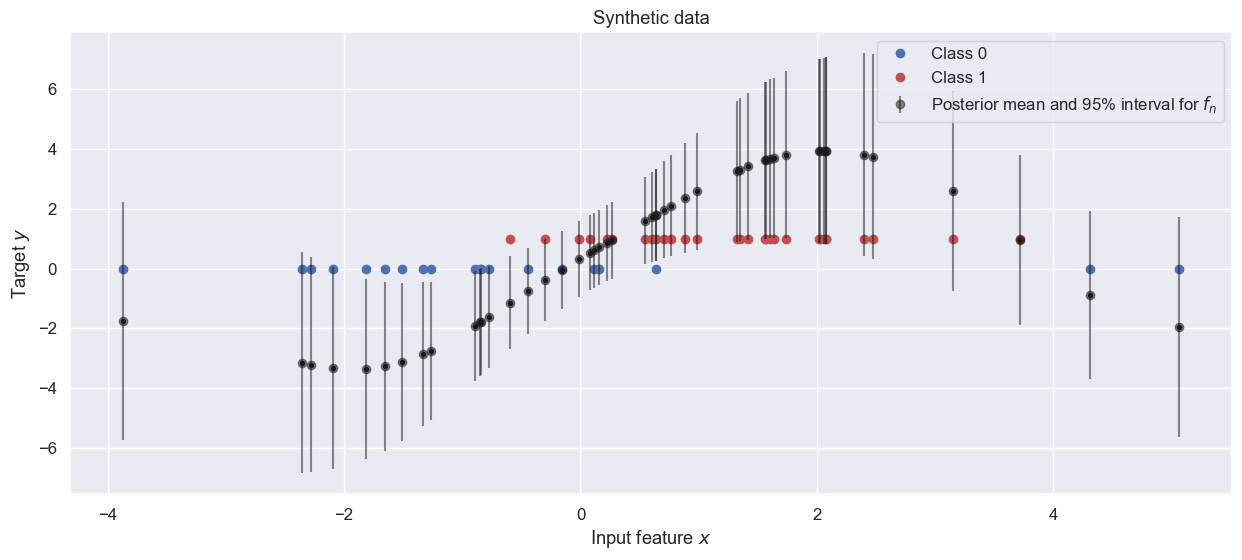

In [11]:
"""
The probit function, defined as the CDF of the standard normal distribution:
    probit(x) = Φ(x) = ∫_{-∞}^{x} (1/√(2π)) exp(-t²/2) dt.
This is sometimes used as the link function in binary classification.
"""
probit = lambda x: norm.cdf(x)

class GaussianProcessClassification(object):
    """
    Gaussian Process Classification using the Laplace approximation.
    
    The latent function f is modeled as a Gaussian Process with a covariance 
    kernel K. The observed labels y are assumed to follow a non-Gaussian likelihood 
    (e.g. Bernoulli with a link function such as the probit or sigmoid).
    
    Since the posterior p(f|y) is not Gaussian, we use a Laplace approximation
    to approximate it by a Gaussian centered at the mode (MAP estimate). 
    
    We perform a reparameterization:
    
        f = K * a,
    
    where a ∈ ℝᴺ. This avoids direct inversion of K during optimization.
    
    The log joint distribution can be written as:
    
        log p(y, f) = log p(y | f) + log p(f)
    
    with the Gaussian prior on f given by:
    
        p(f) = N(0, K)
              = (2π)^(-N/2) |K|^(-1/2) exp(-½ fᵀ K⁻¹ f).
    
    Reparameterizing with f = K * a leads to:
    
        log p(y, f) = log p(y | K*a) - (N/2)*log(2π) - log|L| - ½ aᵀ (K * a)
    
    where L is the Cholesky factor of K.
    """
    
    def __init__(self, X, y, likelihood, kernel, kappa=1., lengthscale=1., jitter=1e-8):
        """
        Initialize the Gaussian Process for Classification.
        
        Arguments:
            X        -- (N x D) array of input points.
            y        -- (N x 1) array of observed binary labels.
            likelihood -- Likelihood class instance (e.g., BernoulliLikelihood) which 
                          will be instantiated with y.
            kernel   -- Instance of a StationaryIsotropicKernel class (e.g., squared exponential).
            kappa    -- Magnitude (positive scalar) for the kernel.
            lengthscale -- Characteristic lengthscale (positive scalar) for the kernel.
            jitter   -- Small non-negative scalar added for numerical stability.
        """
        self.X = X                                                                          # input points (N x D)
        self.y = y                                                                          # observed labels (N x 1)
        self.N = len(X)                                                                     # number of data points
        # Instantiate likelihood with observed labels y.
        self.likelihood = likelihood(y)                                                     # likelihood instance with observed labels y
        self.kernel = kernel                                                               # kernel instance
        self.jitter = jitter                                                              # jitter for numerical stability
        self.set_hyperparameters(kappa, lengthscale)

        # Precompute the training kernel matrix K with added jitter for stability.
        self.K = self.kernel.contruct_kernel(self.X, self.X, jitter=self.jitter)         # training kernel matrix K
        # Compute the Cholesky decomposition of K (i.e., K = L Lᵀ). 
        self.L = jnp.linalg.cholesky(self.K)                                             # Cholesky decomposition of K
        # Construct the Laplace approximation by computing the MAP estimate and the Hessian.
        self.construct_laplace_approximation()                                         # construct Laplace approximation

    def set_hyperparameters(self, kappa, lengthscale):
        """
        Set the kernel hyperparameters.
        
        Arguments:
            kappa       -- Magnitude (positive scalar).
            lengthscale -- Characteristic lengthscale (positive scalar).
        """
        self.kernel.kappa = kappa                                             # set kernel magnitude
        self.kernel.lengthscale = lengthscale                                # set kernel lengthscale

        
    def log_joint_a(self, a):
        """
        Compute the log joint distribution log p(y, f) in the reparameterized space.
        
        The reparameterization is f = K * a, and the log joint is:
        
            log p(y, f) = log p(y | f) + log p(f),
            
        where the prior log p(f) for f ~ N(0, K) is:
        
            log p(f) = -N/2 * log(2π) - log|L| - ½ fᵀ K⁻¹ f.
        
        With f = K*a, the quadratic term becomes ½ aᵀ (K * a).
        
        Arguments:
            a -- Vector of parameters (shape: (N,)).
            
        Returns:
            log_joint -- Scalar value of the log joint distribution.
        """
        # Reparameterize f as f = K * a.
        f = self.K @ a
        
        # Compute the log prior contribution:
        # Constant term: -N/2 * log(2π)
        const = -self.N / 2 * jnp.log(2 * jnp.pi)
        # Log-determinant term computed via Cholesky: log|K| = 2*sum(log(diag(L)))
        logdet = jnp.sum(jnp.log(jnp.diag(self.L)))
        # Quadratic term: ½ aᵀ f (since f = K*a, this is equivalent to ½ fᵀ K⁻¹ f)
        quad_term = 0.5 * jnp.sum(a * f)
        # Combine to form the log prior:
        log_prior = const - logdet - quad_term
        
        # Compute the log likelihood contribution: log p(y | f)
        log_lik = self.likelihood.log_lik(f)
        
        # Return the sum of log prior and log likelihood.
        return log_prior + log_lik
    

    def grad_a(self, a):
        """
        Compute the gradient of the log joint distribution with respect to a.
        
        Since f = K * a, by the chain rule the gradient is:
        
            ∇ₐ log p(y, a) = Kᵀ ∇_f log p(y, f) + ∇ₐ log p(f)
            
        For the prior, the derivative of -½ fᵀ K⁻¹ f with respect to a gives -f,
        and for the likelihood, the gradient w.r.t. f is computed and then multiplied by K.
        
        Arguments:
            a -- Vector of parameters (shape: (N,)).
        
        Returns:
            grad -- Gradient vector of shape (N,).
        """
        # Reparameterize f = K*a.
        f = self.K @ a
        # Gradient from the prior: derivative of -½ aᵀ (K * a) yields -f.
        grad_prior = -f
        # Gradient from the likelihood: compute ∇_f log p(y|f) then chain rule multiplies by K.
        grad_lik = self.likelihood.grad(f) @ self.K
        # Return the sum of the gradient contributions.
        return grad_prior + grad_lik
        
    
    def compute_f_MAP(self):
        """
        Compute the MAP (maximum a posteriori) estimate of the latent function f.
        
        This is done by optimizing the log joint distribution in the a-space:
        
            f = K * a,
            a* = argmaxₐ log p(y, f),
            f_MAP = K * a*.
        
        Returns:
            f_MAP -- The MAP estimate of the latent function (vector of shape (N,)).
        """
        # Optimize the negative log joint (minimization of -log_joint_a)
        result = minimize(lambda a: -self.log_joint_a(a),
                          jac=lambda a: -self.grad_a(a),
                          x0=jnp.zeros((self.N)))
        
        if not result.success:
            print(result)
            raise ValueError('Optimization failed')
        
        # Store the optimal a and compute f_MAP = K * a.
        self.a = result.x
        f_MAP = self.K @ result.x
        return f_MAP

    def construct_laplace_approximation_straight_forward(self):

        # f_MAP
        self.m = self.compute_f_MAP()


        Lambda = -self.likelihood.hessian(self.m)

        self.H = -Lambda - jnp.linalg.inv(self.K)
        self.S = jnp.linalg.inv(-self.H)



    def construct_laplace_approximation(self):
        """
        Constructs the Laplace approximation to the posterior p(f|y) as a Gaussian
            N(f | m, S),
        where:
            m = f_MAP is the MAP (mode) of the latent function,
            S is the approximate posterior covariance.

        The Laplace approximation involves a second-order Taylor expansion of the log 
        posterior around the MAP. In GP classification, the posterior precision is given by

            S⁻¹ = K⁻¹ + Λ,

        where Λ = -∇² log p(y|f)|₍f = m₎ is the negative Hessian of the log likelihood 
        evaluated at the MAP. A direct implementation would compute:

            H = -Λ - K⁻¹,   then   S = (-H)⁻¹.

        However, directly inverting matrices can be numerically unstable. Instead, we use 
        a more robust computation based on a factorization technique (related to the Woodbury 
        identity):

        1. Compute Lsqrt = sqrt(Λ) (elementwise, since Λ is diagonal).
        2. Form the matrix B = I + Lsqrt @ K @ Lsqrt.
        3. Compute the Cholesky decomposition of B: chol_B such that B = chol_B @ chol_Bᵀ.
        4. Solve e = chol_B⁻¹ @ (Lsqrt @ K).
        5. Then the posterior covariance is computed as S = K - eᵀ @ e.
    
        This sequence avoids direct inversion and improves numerical stability.

        Side effects:
            - Sets self.m to the MAP estimate (f_MAP).
            - Sets self.S to the approximate posterior covariance matrix S.
        """
        # Compute the MAP estimate of the latent function, m = f_MAP.
        self.m = self.compute_f_MAP()

        # Compute the negative Hessian of the log likelihood at the MAP:
        # Lambda = -[∇² log p(y|f)] evaluated at f = m.
        Lambda = -self.likelihood.hessian(self.m)

        # ---- Straightforward (but less robust) computation of S ----
        # The direct approach would be:
        # self.H = -Lambda - jnp.linalg.inv(self.K)
        # self.S = jnp.linalg.inv(-self.H)
        # However, direct inversion is numerically sensitive.

        # ---- Numerically robust computation of S using Cholesky factorization ----
        # Compute the elementwise square root of Lambda.
        Lsqrt = jnp.sqrt(Lambda)
        
        # Form the matrix B = I + Lsqrt @ K @ Lsqrt.
        # This step rearranges the inverse of (K⁻¹ + Λ) into a form that avoids direct inversion.
        B = jnp.identity(len(self.m)) + Lsqrt @ self.K @ Lsqrt
        
        # Compute the Cholesky decomposition of B.
        chol_B = jnp.linalg.cholesky(B)
        
        # Solve the linear system: e = chol_B⁻¹ @ (Lsqrt @ K).
        # This avoids explicitly computing the inverse of B.
        e = jnp.linalg.solve(chol_B, Lsqrt @ self.K)
        
        # Finally, compute the posterior covariance using the identity:
        # S = K - (eᵀ @ e)
        self.S = self.K - e.T @ e
        print(f"Dimension of Sigma of Laplace {self.S.shape}")
        print(f"Dimension of mu of Laplace {self.m.shape}")

    def predict_f(self, Xstar):
        """
        Compute the posterior predictive distribution for the latent function at new points Xstar
        under the Laplace approximation to the Gaussian process classification model.

        **Mathematical Formulation:**
        We assume that the posterior over the latent function values f (on the training set) is
        approximated by a Gaussian around the MAP estimate:

            p(f | X, y) ≈ N(m, S),

        where:
          - m = self.m is the MAP estimate of f on the training data.
          - S is the approximate posterior covariance from the Laplace approximation.
          - K = self.K is the (N x N) kernel (covariance) matrix among the training inputs.

        For new test points X*, we define:
          - k_x_x = K, the covariance among training inputs (already computed).
          - k_star_x = K_{*X}, the (P x N) cross-covariance between X* (test) and X (training).
          - k_star_star = K_{**}, the (P x P) covariance among test inputs.

        Using standard GP results adapted for the Laplace approximation, one can derive:

            f* | X*, X, y  ~  N(μ*, Σ*),

        where:

            μ*    = k_star_x K⁻¹ m,
            Σ*    = k_star_star - k_star_x K⁻¹ [K - S] K⁻¹ k_x_star.

        (Note that k_x_star = k_star_xᵀ.)

        **Implementation Details:**
          - We use jnp.linalg.solve(A, B) instead of explicitly computing A⁻¹ B. 
            This is numerically more stable and avoids forming the matrix inverse A⁻¹ directly.
            - Specifically, `jnp.linalg.solve(k_x_x, k_star_x.T)` solves (k_x_x) * X = k_star_x.T for X.
            - This is effectively the same as X = K⁻¹ (k_star_x.T), but more stable.
          - The vector mu is obtained by solving for K⁻¹ m in a similar way.

        Arguments:
        ----------
        Xstar : jnp.ndarray
            (P x D) array of test (prediction) points, where P is the number of test points.

        Returns:
        --------
        mu : jnp.ndarray
            Predictive mean vector of shape (P,). This corresponds to the mean of f* at the new points.
        Sigma : jnp.ndarray
            Predictive covariance matrix of shape (P, P). This corresponds to the covariance of f*.

        Notes:
        ------
        - The Laplace approximation modifies the usual GP predictive formula by replacing
          K⁻¹ with K⁻¹ (K - S) K⁻¹ in one part of the covariance. Here, the code uses
          (k_x_x - self.S) inside the term that gets multiplied by K⁻¹ on both sides.
        """
        # Covariance between test inputs and training inputs
        k_star_x = self.kernel.contruct_kernel(Xstar, self.X, jitter=self.jitter)
        # Covariance among test inputs
        k_star_star = self.kernel.contruct_kernel(Xstar, Xstar, jitter=self.jitter)
        # Training covariance (N x N)
        k_x_x = self.K

        # Solve for K⁻¹ k_star_xᵀ more stably than k_x_x⁻¹ k_star_xᵀ
        h = jnp.linalg.solve(k_x_x, k_star_x.T)
        # Predictive mean: k_star_x K⁻¹ m
        # We again use solve for K⁻¹ m
        mu = k_star_x @ jnp.linalg.solve(k_x_x, self.m)
        # Predictive covariance:
        # Σ* = k_star_star - k_star_x K⁻¹ (K - S) K⁻¹ k_star_xᵀ
        # We already have h = K⁻¹ k_star_xᵀ, so h.T = k_star_x K⁻¹
        # Then (k_x_x - self.S) is (K - S).
        Sigma = k_star_star - h.T @ (k_x_x - self.S) @ h

        # Ensure shapes are correct
        assert (mu.shape == (len(Xstar),)), \
            f"Expected shape for mu is ({len(Xstar)}), but got {mu.shape}."
        assert Sigma.shape == (len(Xstar), len(Xstar)), \
            f"Expected shape for Sigma is ({len(Xstar)}, {len(Xstar)}), but got {Sigma.shape}."

        return mu, Sigma

    
    def predict_y(self, Xstar):
        """
        Compute the posterior predictive probabilities for the observed outputs y* at new points Xstar.
        
        **Mathematical Formulation:**
        In Gaussian process classification with a probit (or other link) function, the probability of y* = 1
        at a new point x* is:
        
            p(y* = 1 | x*, X, y) = ∫ Φ(f*) p(f* | x*, X, y) df*,
        
        where Φ(·) is the standard normal CDF (the probit function) and p(f* | x*, X, y) is the predictive
        distribution of the latent function f* (Gaussian under the Laplace approximation).
        
        Since this integral does not have a closed form, a common approximation is:
        
            p ≈ Φ( μ* / √(1 + σ*²) ),
        
        where μ* is the predictive mean and σ*² is the predictive variance. In the code below, a similar
        approximation is used:
        
            p = probit( mu / sqrt( some_constant + diag(Sigma) ) ),
        
        which accounts for the latent function variance in the denominator in a heuristic or model-specific way.
        
        **Implementation Details:**
          - We first call self.predict_f(Xstar) to obtain:
              (μ*, Σ*) = (mu, Sigma),
            the predictive mean and covariance for the latent function at Xstar.
          - We then apply the probit function to an adjusted version of μ* that incorporates its uncertainty.
          - The result p is the vector of approximate predictive probabilities.
        
        Arguments:
        ----------
        Xstar : jnp.ndarray
            (P x D) array of test (prediction) points.
        
        Returns:
        --------
        p : jnp.ndarray
            Vector of posterior predictive probabilities for y* = 1 at each of the P points, shape (P,).
        """
        # Get predictive mean (mu) and covariance (Sigma) for f*
        mu, Sigma = self.predict_f(Xstar)
        
        # Apply the probit function with a variance adjustment
        # (the exact factor 8/pi is a heuristic or model-specific approximation).
        p = probit(mu / jnp.sqrt(8 / jnp.pi + jnp.diag(Sigma)))
        
        # Check shape and return
        assert (p.shape == (len(Xstar),)), \
            f"Expected shape for p is ({len(Xstar)}), but got {p.shape}."
        return p
    
    
    def posterior_samples(self, Xstar, num_samples):
        """
        Generate samples from the posterior predictive distribution p(f* | y, X*) for each of the inputs in Xstar.
        
        **Mathematical Formulation:**
        Under the Laplace approximation, the predictive distribution of the latent function at new points Xstar
        is assumed to be Gaussian:
        
            f* ~ N(μ*, Σ*),
        
        where μ* and Σ* come from self.predict_f(Xstar). To generate samples, we draw from this multivariate
        normal distribution.
        
        **Implementation Details:**
          - We first obtain the mean (mu) and covariance (Sigma) for f* by calling self.predict_f(Xstar).
          - We then call generate_samples(mu, Sigma, num_samples) which should return a (P, num_samples) array,
            where P = len(Xstar).
          - Each column of the result is one sample of the latent function at all test points.
        
        Arguments:
        ----------
        Xstar : jnp.ndarray
            (P x D) array of test (prediction) points.
        num_samples : int
            Number of samples to draw from the posterior predictive distribution for each test point.
        
        Returns:
        --------
        f_samples : jnp.ndarray
            A (P, num_samples) array containing draws from the approximate posterior predictive distribution
            of the latent function at Xstar.
        """
        # Obtain the predictive mean and covariance for the latent function
        mu, Sigma = self.predict_f(Xstar)
        
        # Generate samples from a multivariate normal N(mu, Sigma)
        f_samples = generate_samples(mu.ravel(), Sigma, num_samples)
        
        # Check shape and return
        assert (f_samples.shape == (len(Xstar), num_samples)), \
            f"Expected shape for f_samples is ({len(Xstar)}, {num_samples}), but got {f_samples.shape}."
        return f_samples


# prep kernel, likelihood and Gaussian process
kernel = StationaryIsotropicKernel(squared_exponential)
likelihood = BernoulliLikelihood
gpc = GaussianProcessClassification(X, y, likelihood, kernel, kappa=3., lengthscale=1)

# plot data and visualize posterior
fig, ax = plt.subplots(1, 1, figsize=(15, 6))
plot_data(ax, X, y)
ax.plot(X, gpc.m, 'k.')
ax.errorbar(X, gpc.m, yerr=1.96*jnp.sqrt(jnp.diag(gpc.S)), fmt='ko', label='Posterior mean and 95% interval for $f_n$', alpha=0.5)
ax.legend();

If your implementation is correct, the code above visualizes the Laplace approximation superimposed on the data.

**Task 2.4**: Explain what you see in the plot above. That is, what does the entries of the posterior mean vector $\mathbf{m}$ represent? What about the entries in the posterior covariance matric $\mathbf{S}$? [**Discussion question**]

*Hints: What are the dimensions of the mean $\mathbf{m}$ and the covariance $\mathbf{S}$ of the Laplace approximation?*

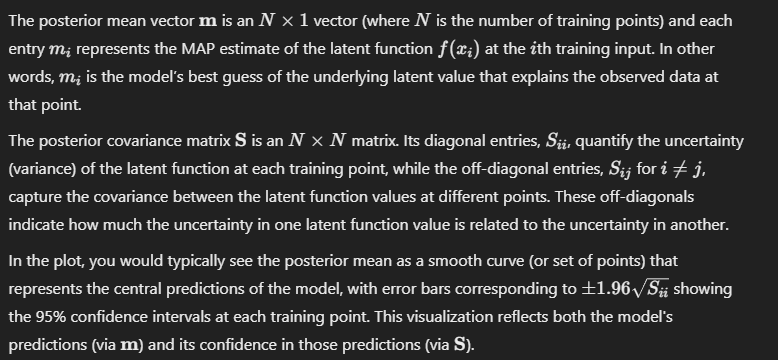

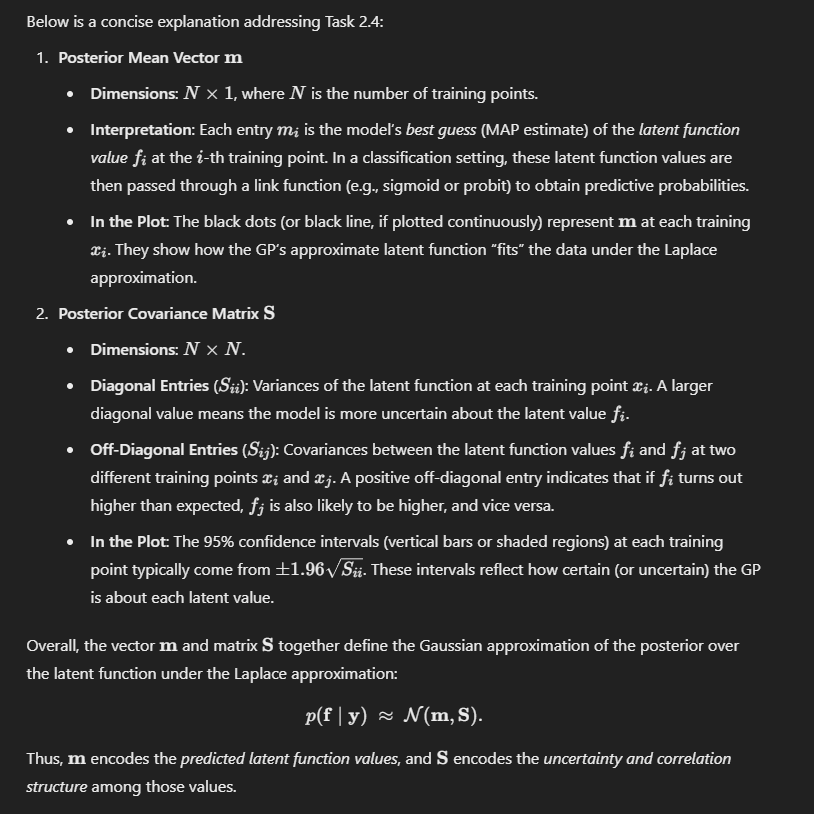

## Part 3:  Implementing the posterior distribution of $p(f^*|\mathbf{y}, \mathbf{x}^*)$ (step 2 of 3)

We are now ready for step 2, which is to compute the posterior distribution of the latent function evaluated at a new point $\mathbf{x}^*$, i.e to compute $p(f^*|\mathbf{y}, \mathbf{x}^*)$ where $f^* = f(\mathbf{x}^*)$. Informally, we want to be able to "fill the gaps" in the plot above.

Using the posterior approximation $q(\mathbf{f}) = \mathcal{N}(\mathbf{f}|\mathbf{m}, \mathbf{S})$, we can compute the approximate posterior for $f^* = f(\mathbf{x}^*)$ when evaluated at any $\mathbf{x}^*$ as follows:

$$\begin{align*}
p(f^*|\mathbf{y}, \mathbf{x}^*) &= \int p(f^*|\mathbf{f}, \mathbf{x}^*) p(\mathbf{f}|\mathbf{y}) \text{d} \mathbf{f}\approx  \int p(f^*|\mathbf{f}, \mathbf{x}^*) q(\mathbf{f}) \text{d} \mathbf{f}.
\end{align*}$$

Since $p(\mathbf{f}, f^*)$ is a multivariate Gaussian, the conditional distribution $p(f^*|\mathbf{f}, \mathbf{x}^*)$ will also be a Gaussian, where the mean and covariance is given by the general equations on p. 84 in Murphy1 (you will derive them below). 





Moreover, since $q(\mathbf{f})$ is also Gaussian, we can solve the integral above by recognizing that this integral is equivalent to a marginalization in a linear Gaussian system (see Section 3.3 in Murphy1). The results becomes

$$\begin{align*}
p(f^*|\mathbf{y}, \mathbf{x}^*) \approx  \mathcal{N}(f^*|\mu_{f^*|\mathbf{y}}, \sigma^2_{f^*|\mathbf{y}}),
\end{align*}$$

where 

$$\begin{align*}
\mu_{f^*|\mathbf{y}} &=  \mathbf{k}^T \mathbf{K}^{-1} \mathbf{m},\\
\sigma^2_{f^*|\mathbf{y}} &= c - \mathbf{k}^T \mathbf{K}^{-1} (\mathbf{K} - \mathbf{S}) \mathbf{K}^{-1} \mathbf{k}
\end{align*}$$

where $c = k(\mathbf{x}_*, \mathbf{x}_*)$ is the prior variance of $f^*$, $\mathbf{k} \in \mathbb{R}^N$ is a vector with entries given by $\mathbf{k}_n = k(\mathbf{x}_*, \mathbf{x}_n)$, and $\mathbf{K} \in \mathbb{R}^{N \times N}$ is prior covariance of $\mathbf{f}$. If you want to compute the joint distribution the predictions for $P$ input points $\mathbf{x}^*$ at once, then $\mathbf{k}$ becomes a $P \times N$-matrix and $c$ becomes a $P \times P$-matrix.






_______________________________________________

Before implementing this part, we will elaborate a bit on some of the details above. 


**Task 3.1**: Write the expression for the prior mean and the prior covariance matrix for the joint Gaussian distribution $p( f^*, \mathbf{f})$ in terms of the kernel quantitites $\mathbf{K}$, $\mathbf{k}$ and $k$.

*Hints: What is the prior mean of $\mathbf{f}$ and $f^*$? What is the prior variance of $\mathbf{f}$ and $f^*$? What is the prior covariance between $\mathbf{f}$ and $f^*$?*

**Solution**

By assumption, the prior mean of $f(\mathbf{x})$ is 0 for all $\mathbf{x}$. Therefore, $\mathbb{E}\left[\mathbf{f}\right] = \mathbb{0}$ and $\mathbb{E}\left[f^*\right] = 0$.
Moreover, the prior variance of $f(\mathbf{x})$ is $k(\mathbf{x}, \mathbf{x})$ for any $\mathbf{x}$, i.e. $\mathbb{V}\left[f(\mathbf{x})\right] = k(\mathbf{x}, \mathbf{x})$. Finally, the covariance between $f(\mathbf{x}^*)$ and $f(\mathbf{x})$ is given by $\text{cov}(f(\mathbf{x}^*), f(\mathbf{x})) = k(\mathbf{x}^*, \mathbf{x})$

Therefore, we have that $\mathbb{V}\left[\mathbf{f}\right] = \mathbf{K}$, $\mathbb{V}\left[f^*\right] = k(\mathbf{x}^*, \mathbf{x}^*)$, and $\text{cov}\left(\mathbf{f}, f^*\right) = \mathbf{k}$. Combining  this yields the multivariate normal distribution:

$$\begin{align*}
p(f^*, \mathbf{f}) = \mathcal{N}\left(\begin{bmatrix}f^*  \\ \mathbf{f}\end{bmatrix}|\begin{bmatrix}0 \\ \mathbf{0} \end{bmatrix}, \begin{bmatrix} k(\mathbf{x}^*, \mathbf{x}^*) & \mathbf{k}^T \\ \mathbf{k} & \mathbf{K} \end{bmatrix}\right)
\end{align*}
$$

**End of solution**

_____
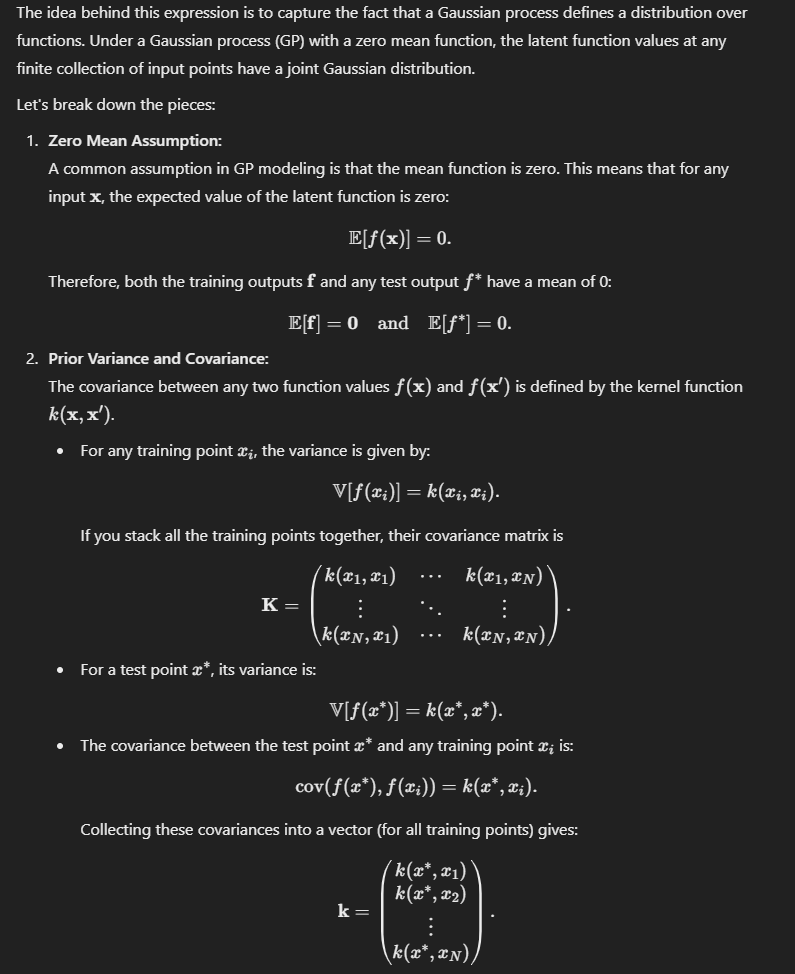
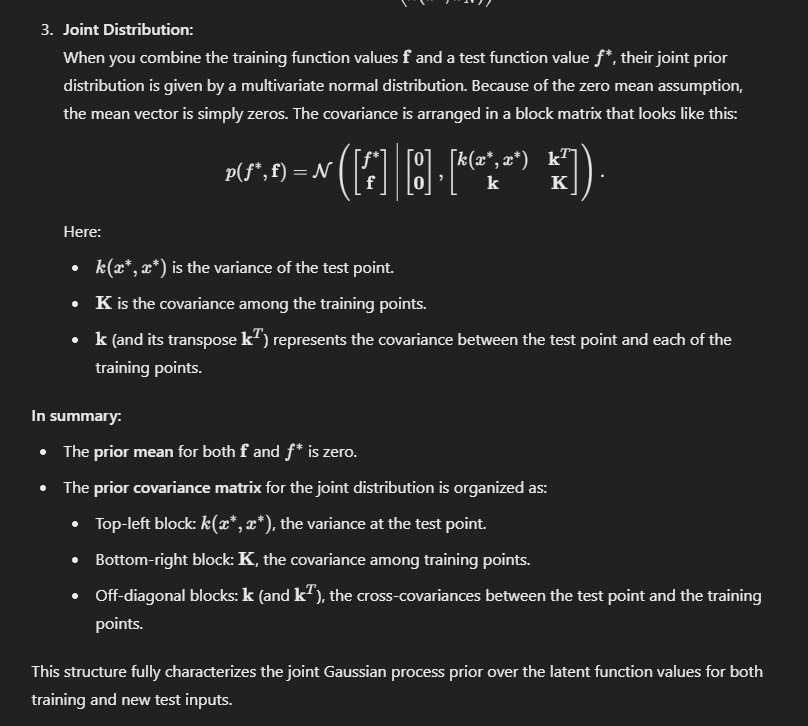
___


**Note**: The next task will make you of your solution from the previous task, so you might want to verify it before continuing.



**Task 3.2**: Write the expression for the mean and covariance of the conditional distribution $p(f^*|\mathbf{f}, \mathbf{x}^*)$ using the solution to the previous task.

*Hints: Use the equations (3.26) and (3.28)  on p. 84 in Murphy1.*

**Solution**

By comparing our distribution with the distribution in eq. (3.26) in Murphy1, we see that $\mathbf{y}_1 = f^*$, $\mathbf{y}_2 = \mathbf{f}$, $\mu_1 = \mu_2 = 0$,  $\Sigma_{11} = k(\mathbf{x}^*, \mathbf{x}^*)$, $\Sigma_{22} = \mathbf{K}$, and $\Sigma_{12} = \mathbf{k}^T$. Using eq. (3.28) then yields

$$\begin{align*}
p(f^*|\mathbf{f}, \mathbf{x}^*) &= \mathcal{N}(f^*|\mu_{f^*|\mathbf{f}}, \sigma^2_{f^*|\mathbf{f}}),\\
\mu_{f^*|\mathbf{f}} &= \mathbf{k}^T \mathbf{K}^{-1}\mathbf{f} \\
 \sigma^2_{f^*|\mathbf{f}} &= k(\mathbf{x}^*, \mathbf{x}^*) - \mathbf{k}^T \mathbf{K}^{-1} \mathbf{k}
\end{align*}$$

or equivalently

$$\begin{align*}
p(f^*|\mathbf{f}, \mathbf{x}^*) &= \mathcal{N}(f^*|\, \mathbf{k}^T \mathbf{K}^{-1}\mathbf{f} \, , \, k(\mathbf{x}^*, \mathbf{x}^*) - \mathbf{k}^T \mathbf{K}^{-1} \mathbf{k})
\end{align*}
$$

The distribution $p(f^*|\mathbf{y}, \mathbf{x}^*)$ given above can now be derived using eq. (3.38) from Murphy1.

**End of solution**
_______________

We are now ready to implemenet the distribution $p(f^*|\mathbf{y}, \mathbf{x}^*)$.

**Task 3.3**: Go back up the class `GaussianProcessClassification` and complete the implementation of the function `predict_f` using the equations above.

Dimension of Sigma of Laplace (50, 50)
Dimension of mu of Laplace (50,)


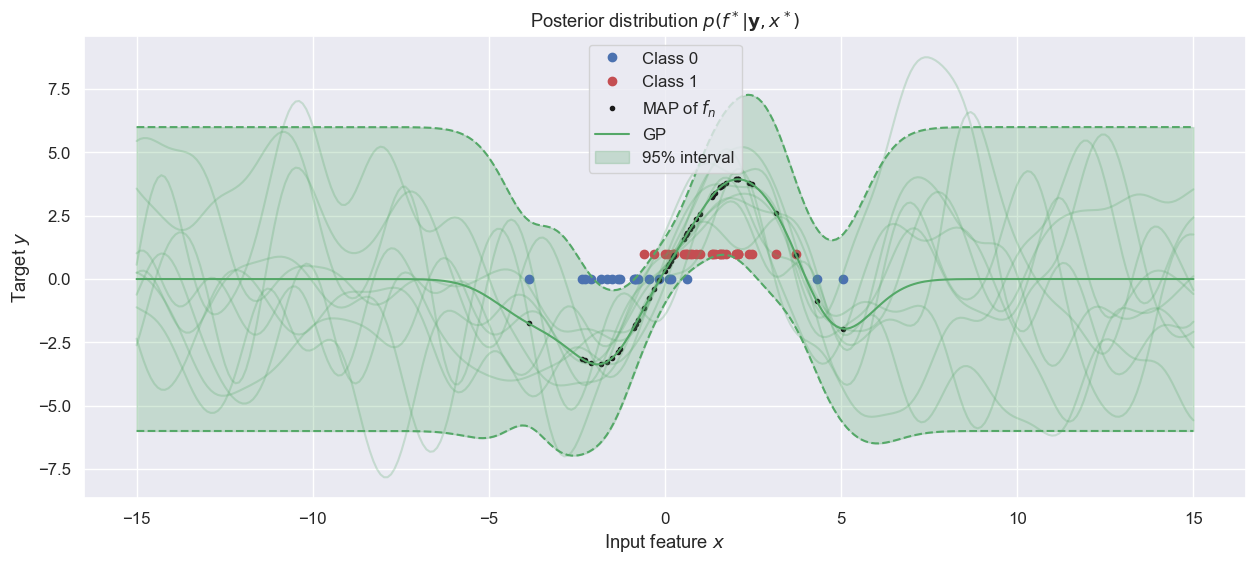

In [23]:
# -------------------------------------------------------------------------
# Create a new kernel instance using the squared_exponential function.
# This kernel function determines how points in the input space correlate
# with each other in the Gaussian process.
# -------------------------------------------------------------------------
kernel = StationaryIsotropicKernel(squared_exponential)

# -------------------------------------------------------------------------
# Choose a Bernoulli likelihood for binary classification.
# In this likelihood, the probability of a label y=1 is modeled via a
# link function (e.g., sigmoid) applied to the latent function f.
# -------------------------------------------------------------------------
likelihood = BernoulliLikelihood

# -------------------------------------------------------------------------
# Instantiate the GaussianProcessClassification (GPC) object with:
#   - Training data (X, y)
#   - The specified kernel and likelihood
#   - Hyperparameters kappa (magnitude) and lengthscale
#   - A small jitter for numerical stability (if applicable)
#   - The Laplace approximation is automatically constructed within the GPC class,
#     finding the MAP estimate and approximate posterior covariance.
#
# Note: kappa=3.0 sets a relatively large signal variance, and lengthscale=1
#       determines how quickly correlations decay with distance.
# -------------------------------------------------------------------------
gpc = GaussianProcessClassification(X, y, likelihood, kernel, kappa=3., lengthscale=1)

# -------------------------------------------------------------------------
# predict the latent function f at new points Xstar using the GPC model.
# The predict_f method computes the posterior predictive distribution for the latent function
# at the new points, returning the mean (mu) and covariance (Sigma).
# add equtions:

mu, Sigma = gpc.predict_f(Xstar)

# -------------------------------------------------------------------------
# Create a figure and axes for plotting the results.
# -------------------------------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

# -------------------------------------------------------------------------
# Plot the training data (input points X and binary labels y).
# Here, plot_data is a helper function that visualizes the inputs and
# their corresponding class labels in some 2D or 1D representation.
# -------------------------------------------------------------------------
plot_data(ax, X, y)

# -------------------------------------------------------------------------
# Plot the MAP estimate of the latent function (gpc.m) at the training points X.
# The MAP estimate gpc.m is an N-dimensional vector (where N is the number
# of training points), representing the most likely latent function values
# that explain the observed data under the GP model.
# -------------------------------------------------------------------------
ax.plot(X, gpc.m, 'k.', label='MAP of $f_n$')

# -------------------------------------------------------------------------
# Plot approximate posterior uncertainty around the MAP estimate:
#   - The matrix gpc.S is the approximate posterior covariance of the latent
#     function under the Laplace approximation. Its diagonal elements
#     (diag(gpc.S)) give the variances for each training point.
#   - We take ±1.96 * sqrt(diag(gpc.S)) to plot an approximate 95% confidence
#     interval around the MAP estimate. This interval indicates how certain
#     the model is about each latent function value at the training points.
# -------------------------------------------------------------------------
#ax.errorbar(
#    X,
#    gpc.m,
#    yerr=1.96 * jnp.sqrt(jnp.diag(gpc.S)),
#    fmt='ko',
#    label='Posterior mean and 95% interval for $f_n$',
#    alpha=0.5
#)

plot_with_uncertainty(ax, Xstar, mu, Sigma, color='g', title='Posterior distribution $p(f^*|\\mathbf{y}, x^*)$', num_samples=10)
# -------------------------------------------------------------------------
# Add a legend to distinguish the data, MAP estimate, and uncertainty intervals.
# -------------------------------------------------------------------------
ax.legend()


**Task 3.4**: Play around with the kernel and hyperparameter settings and describe how they affect the resulting plot [**Discussion question**]

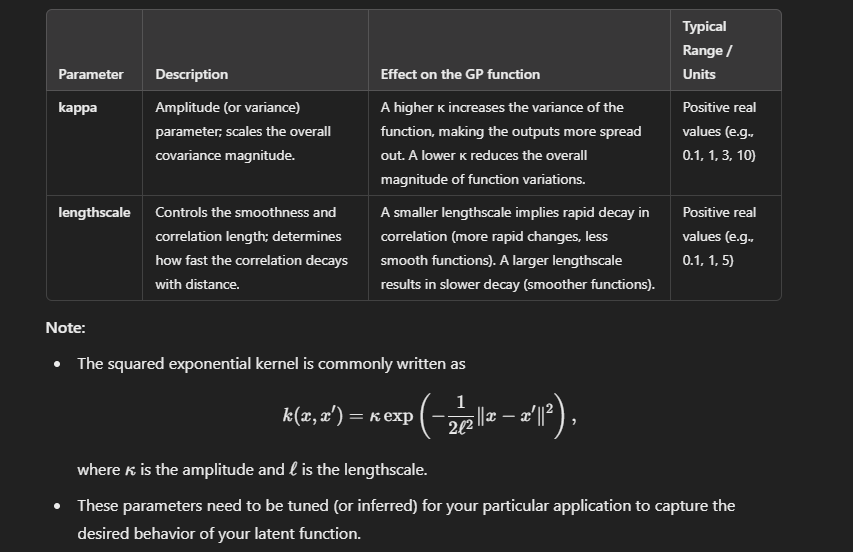

## Part 4:  Compute the posterior predictive distribution of the label $y^*$ for the input point $\mathbf{x}^*$, i.e. to compute $p(y^*|\mathbf{y}, \mathbf{x}^*)$. (Step 3 of 3)


Finally, after having obtained the distribution $p(f^*|\mathbf{y})$, we can use this distribution to compute the posterior predictive distribution $p(y^*|\mathbf{y}, \mathbf{x}^*)$

$$
\begin{align*}
p(y^* = 1|\mathbf{y}, \mathbf{x}^*) \approx \int \sigma(f^*) p(f^*|\mathbf{y}) \text{d} f^*.
\end{align*}
$$

We will use the **probit approximation**, which approximates the sigmoid as follows: $\sigma(f^*) \approx \Phi(f^* \sqrt{\frac{\pi}{8}})$, where $\Phi$ is the cumulative distribution function of the standard normal distribution. The benefit is that the expectation value of the approximation can be computed analytically as follows:
$$
\begin{align*}
p(y^* = 1|\mathbf{y}, \mathbf{x}^*) \approx \int \sigma(f^*) p(f^*|\mathbf{y}, \mathbf{x}^*) \text{d} f^* \approx \int \phi\left(f^* \sqrt{\frac{\pi}{8}}\right) p(f^*|\mathbf{y}, \mathbf{x}^*) \text{d} f^* = \Phi\left(\frac{\mu_{f^*}}{\sqrt{\frac{8}{\pi} + \sigma^2_{f^*}}}\right) \tag{3}
\end{align*}
$$

**Task 4.1**: Go back up the class `GaussianProcessClassification` and complete the implementation of the function `predict_y` using the probit approximation.


Dimension of Sigma of Laplace (50, 50)
Dimension of mu of Laplace (50,)


[Text(0.5, 1.0, '$p(y^*=1|\\mathbf{y}, \\mathbf{x}^*)$')]

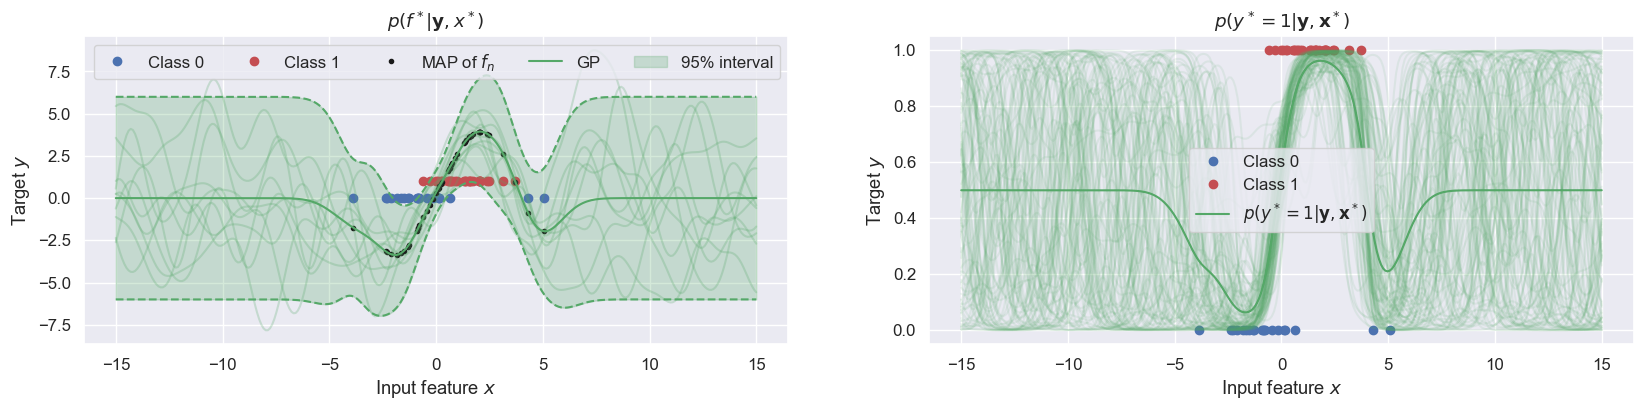

In [24]:
# -------------------------------------------------------------------------
# Set random seed for reproducibility
# -------------------------------------------------------------------------
# A fixed random seed (here 123) ensures that the random number generator produces
# the same sequence of random numbers every time, which is important for reproducible results.
# Equation (for reproducibility, not a mathematical equation): key = random.PRNGKey(123)
key = random.PRNGKey(123)

# -------------------------------------------------------------------------
# Prepare the Gaussian Process Classification (GPC) model
# -------------------------------------------------------------------------
# Create an instance of the kernel using the squared_exponential function.
# The squared exponential kernel is given by:
#     k(x, x') = κ exp( - (1/(2ℓ²)) ||x - x'||² )
# where κ (kappa) is the signal variance and ℓ (lengthscale) determines the smoothness.
kernel = StationaryIsotropicKernel(squared_exponential)

# Choose a Bernoulli likelihood for binary classification.
# Under the Bernoulli likelihood, the probability for y=1 is modeled as:
#     p(y=1 | f) = σ(f) = 1 / (1 + exp(-f))
likelihood = BernoulliLikelihood

# Instantiate the GaussianProcessClassification model with:
#   - X: Training input points (N x D)
#   - y: Training observed binary labels (N x 1)
#   - likelihood: The chosen likelihood instance (Bernoulli)
#   - kernel: The kernel instance (squared exponential)
#   - kappa and lengthscale: Hyperparameters for the kernel
# The model uses the Laplace approximation, which approximates the posterior
# p(f | X, y) as a Gaussian: N(f | m, S), where:
#     m = f_MAP (the MAP estimate) and S is the approximate covariance.
gpc = GaussianProcessClassification(X, y, likelihood, kernel, kappa=3., lengthscale=1.)

# -------------------------------------------------------------------------
# Compute predictions for new test inputs Xstar
# -------------------------------------------------------------------------
# Predict the latent function's posterior distribution at test inputs Xstar.
# The predictive distribution is approximated as:
#     p(f* | X*, X, y) ≈ N(μ*, Σ*)
# with:
#     μ* = K_*X K⁻¹ m,
#     Σ* = K_** − K_*X K⁻¹ K_X*,
# where:
#   - K_*X is the cross-covariance between test inputs and training inputs.
#   - K_** is the covariance among test inputs.
#   - K is the training covariance matrix.
#   - m is the MAP estimate of the latent function.
mu, Sigma = gpc.predict_f(Xstar)

# Predict the posterior predictive probabilities for the observed outputs y*.
# For binary classification, the predictive probability is obtained by mapping
# the latent function f* to the interval [0,1] via the link function:
#     p(y*=1 | f*) = σ(f*) = 1 / (1 + exp(-f*))
# In practice, we apply this mapping to the predictive distribution.
p = gpc.predict_y(Xstar)

# -------------------------------------------------------------------------
# Generate samples from the posterior predictive distribution for f*
# -------------------------------------------------------------------------
# generate_samples is a function that draws samples from a multivariate normal distribution.
# Given the predictive distribution for f*:
#     f* ~ N(μ*, Σ*)
# we generate 100 samples.
# The notation mu[:, None] reshapes mu to a column vector if needed.
# The samples have shape (P, 100), and are then transposed so that each column is one sample across test points.
f_samples = generate_samples(key, mu[:, None], Sigma, 100).T

# Map the latent function samples to predictive probabilities.
# We use the sigmoid function (the logistic function) because the Bernoulli likelihood
# requires probabilities in [0,1]:
#     σ(f) = 1 / (1 + exp(-f))
# Thus, applying sigmoid to the latent samples yields p_samples that approximate:
#     p(y*=1 | X*, X, y)
p_samples = sigmoid(f_samples)

# -------------------------------------------------------------------------
# Plot the results
# -------------------------------------------------------------------------
# Create a figure with 1 row and 2 columns to visualize:
#   - The latent function's predictive distribution.
#   - The predictive probabilities for y*=1.
fig, ax = plt.subplots(1, 2, figsize=(20, 4))

# Plot the training data on both subplots.
plot_data(ax[0], X, y)
plot_data(ax[1], X, y)

# On the first subplot, plot the MAP estimate of the latent function (gpc.m) at the training inputs.
ax[0].plot(X, gpc.m, 'k.', label='MAP of $f_n$')

# Visualize the predictive distribution for the latent function f*:
# plot_with_uncertainty shows the predictive mean μ* and uncertainty (±1.96√diag(Σ*))
# Here, the color 'g' (green) is used, and num_samples=10 indicates the number of samples to show.
plot_with_uncertainty(ax[0], Xstar, mu, Sigma, color='g',
                       title='$p(f^*|\\mathbf{y}, x^*)$', num_samples=10)
ax[0].legend(ncol=5)

# On the second subplot, plot the predictive probabilities for y*=1.
# First, plot the mean predictive probability p as a green line.
ax[1].plot(Xstar, p, 'g-', label='$p(y^*=1|\\mathbf{y}, \\mathbf{x}^*)$')
# Then, overlay individual sampled predictive probabilities (p_samples) with transparency.
ax[1].plot(Xstar.ravel(), p_samples.T, 'g-', alpha=0.1)
ax[1].legend()
ax[1].set(title='$p(y^*=1|\\mathbf{y}, \\mathbf{x}^*)$')

# -----------------------------------------------------------------------------
# Why do we use the sigmoid to map the f_samples?
#
# The latent function f* produced by the GP is unbounded (i.e., it can take any real value).
# However, for binary classification, we need to interpret these values as probabilities,
# which must lie in the interval [0, 1]. The sigmoid function (also known as the logistic function)
# converts any real-valued input into a value between 0 and 1:
#
#     σ(f) = 1 / (1 + exp(-f))
#
# Therefore, by applying the sigmoid to f_samples, we obtain samples of the predictive probability
# for y*=1, ensuring that the outputs can be interpreted as valid probabilities.
# -----------------------------------------------------------------------------


If the code has been implemented correct, the code above produces plot of the posterior distribution $p(f^*|\mathbf{y}, \mathbf{x}^*)$ and the posterior predictive $p(y^*=1|\mathbf{y}, \mathbf{x}^*)$

**Task 4.2**: Inspect the plots above. Comment on the behavior of the posterior predictive distribution. Which regions of the input space is dominated by aleatoric uncertainty and which are dominated by epistemic uncertainty? [**Discussion questions**]

For comparison, we will set-up a simple neural network model as a baseline. We will use a two layer network with 20 neuron in each hidden layer. We will impose an i.i.d. Gaussian prior on all the weights, i.e. $p(w_i) \sim \mathcal{N}(0, \alpha^{-1})$ and use a MAP-estimator for the weights. We will not dive into the details of this model, but simply use it as a baseline. The class `NeuralNetworkMAP` implements estimator a MAP-estimator for the neural network model and the code can be found in the module called `exercise6.py` if you are curious.

The cell below shows the predictive distribution for the network obtained using the plugin approximation compared with the Guassian process:


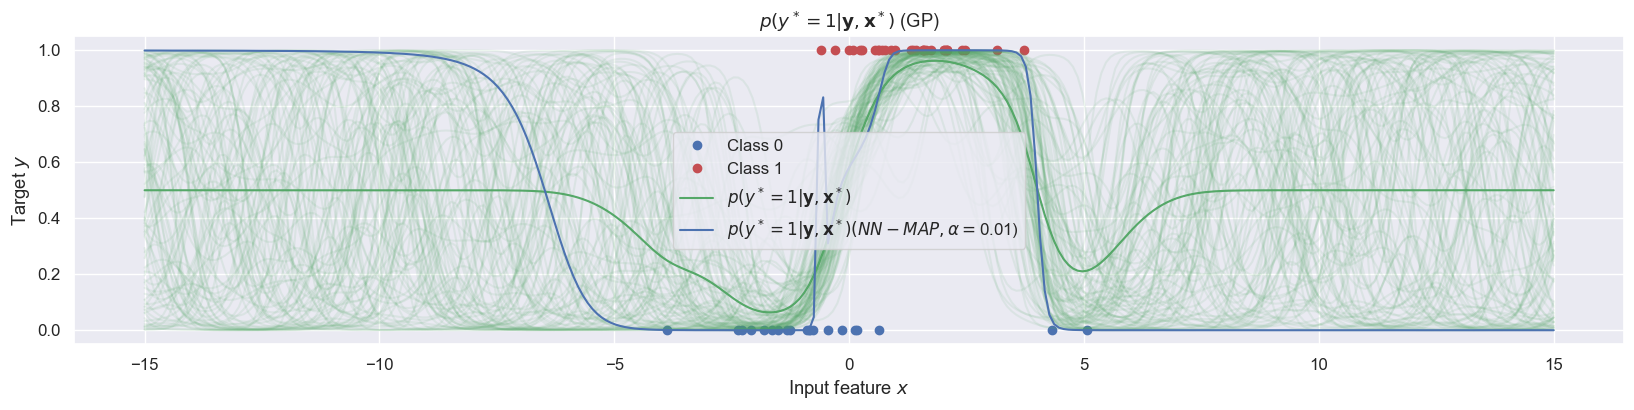

In [25]:
ALPHA = 0.01


# fit the NN model with 1 input dimension, 2 hidden layers of 20 neurons each, and 1 output
nn = NeuralNetworkMAP(X, y, [1, 20, 20, 1], alpha=ALPHA, likelihood=BernoulliLikelihood)

# predict using neural network
y_nn = nn.predict(Xstar)
p_nn = sigmoid(y_nn)

# plot
fig, ax = plt.subplots(1, 1, figsize=(20, 4))
plot_data(ax, X, y)
ax.plot(Xstar, p, 'g-', label='$p(y^*=1|\\mathbf{y}, \\mathbf{x}^*)$')
ax.plot(Xstar.ravel(), p_samples.T, 'g-', alpha=0.1)
ax.set(title='$p(y^*=1|\\mathbf{y}, \\mathbf{x}^*)$ (GP)');
label_str = fr"$p(y^*=1|\mathbf{{y}}, \mathbf{{x}}^*) (NN-MAP, \alpha=${ALPHA:.2f})"
ax.plot(Xstar, p_nn, label=label_str)
ax.legend();



**Task 4.3**: Compare the predictive distribution for the neural network and the Gaussian process. How do they differ (qualitatively) within the support of the data?
 Outside the support of the data? [**Discussion question**]

 *Hint*: Go to the top of the notebook and increase the prediction range for `Xstar`, e.g. from $\left[-7.5, 7.5\right]$ to $\left[-15, 15\right]$

 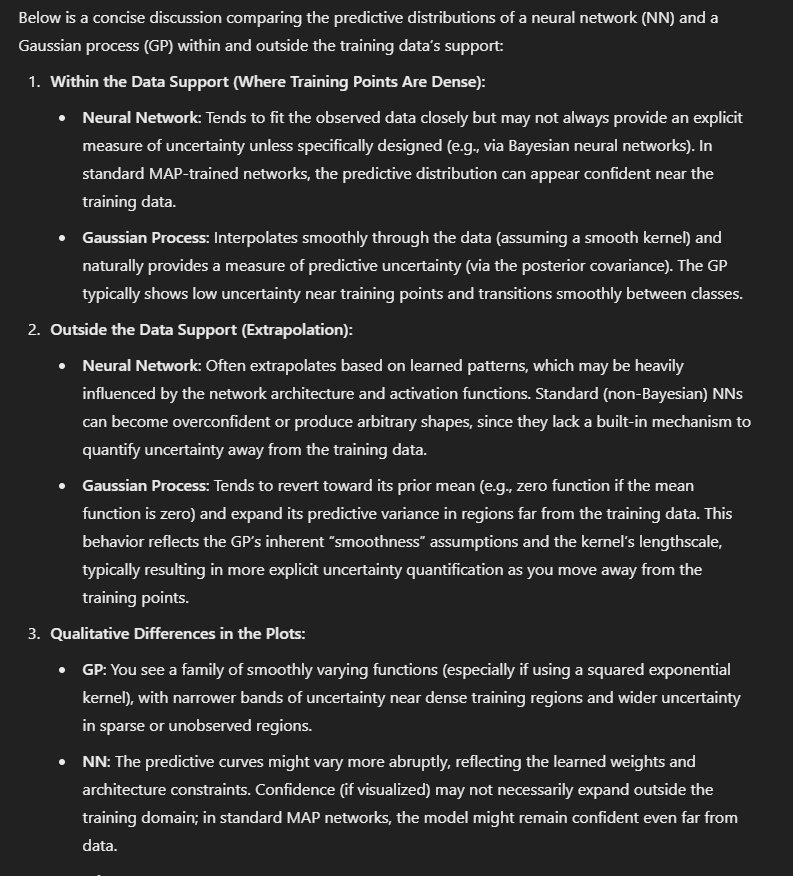
 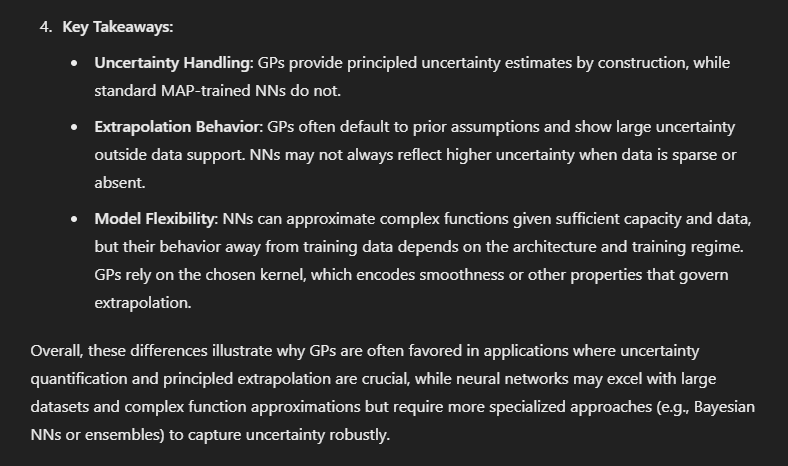



**Task 4.4**: What happens if you increase $\alpha$ from $1$ to e.g. $10$ or decrease it to $0.01$? Can you explain the result? **[Discussion question]**
____
#### $\alpha = 1$
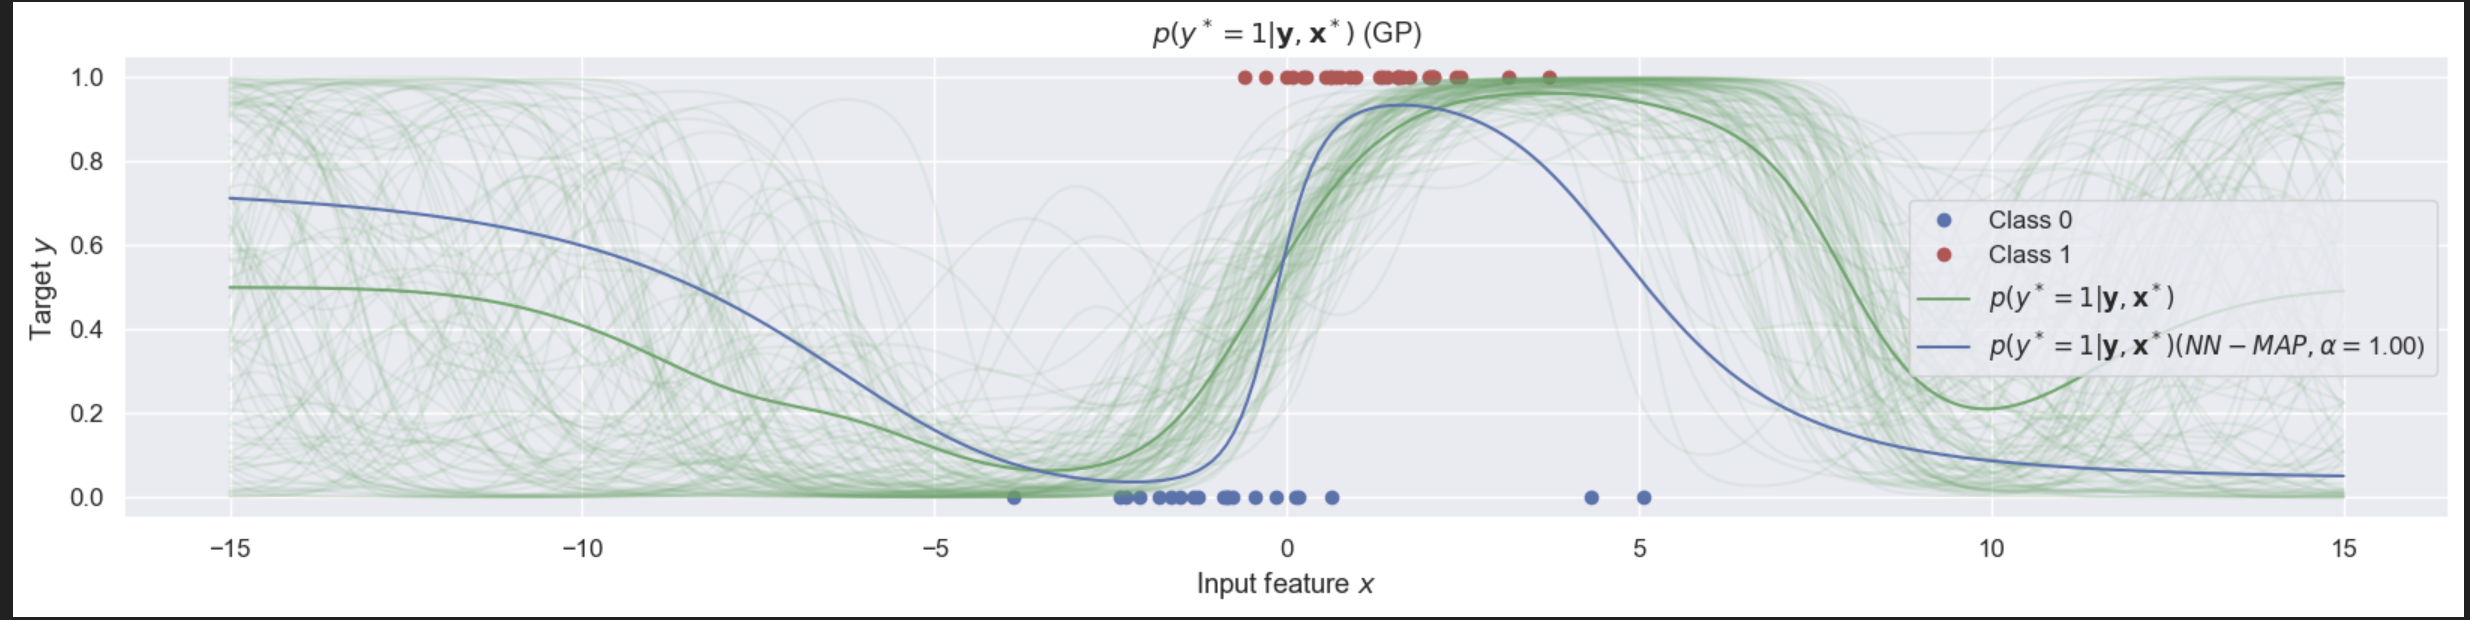
____
#### $\alpha = 10$
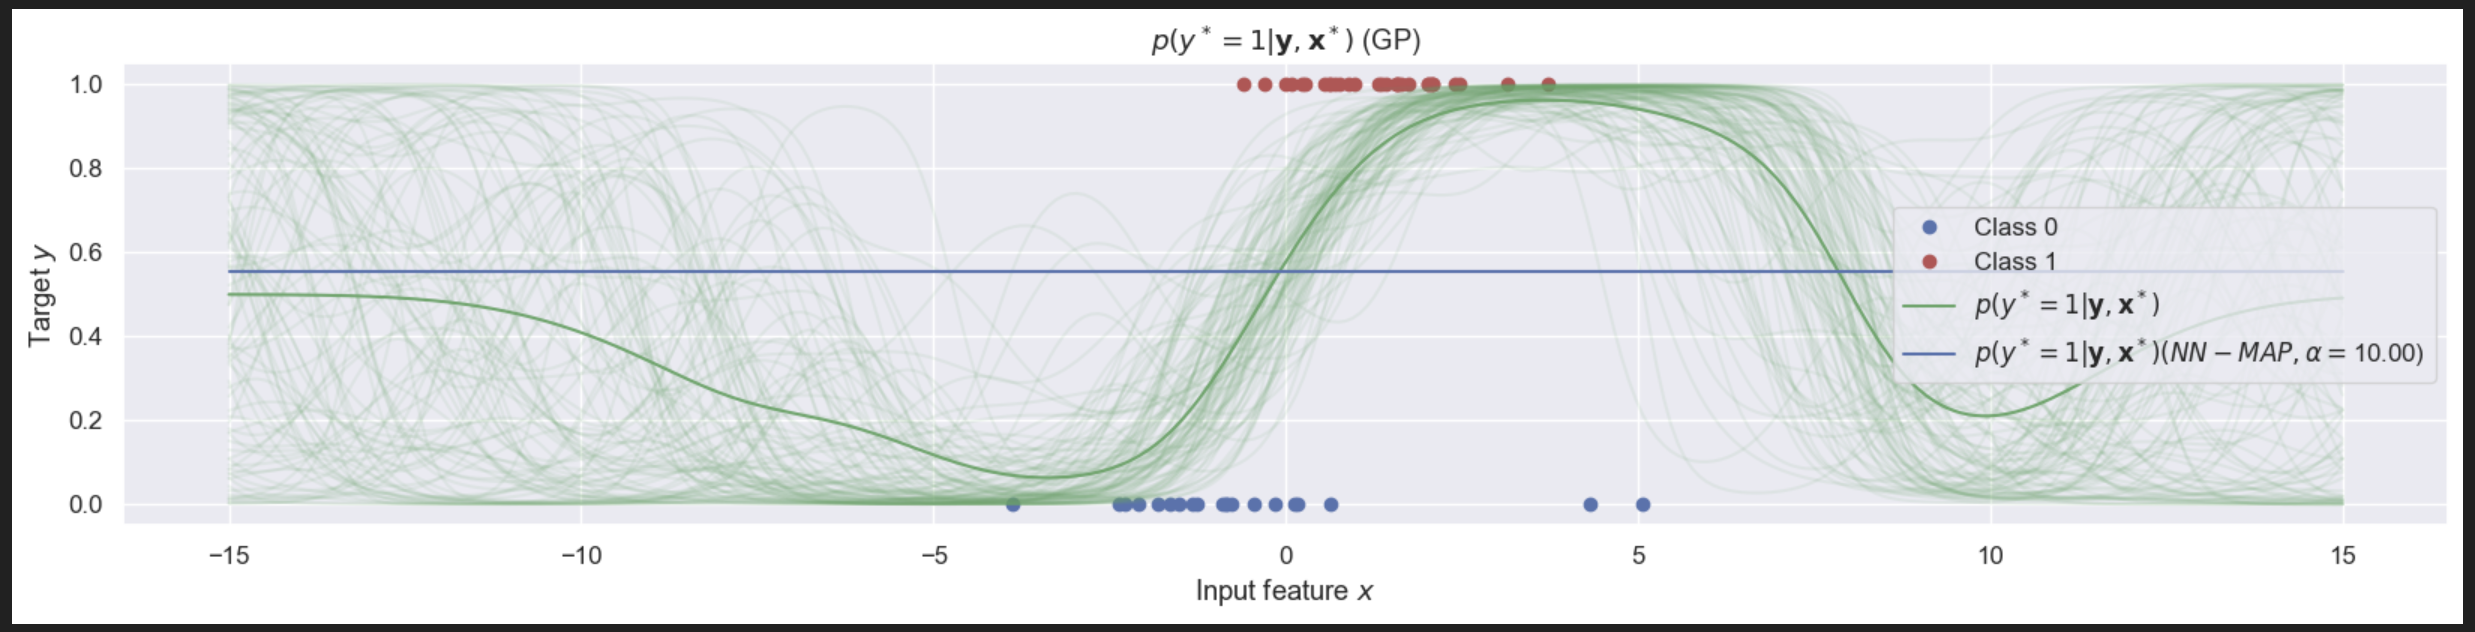
____
#### $\alpha = 0.01$
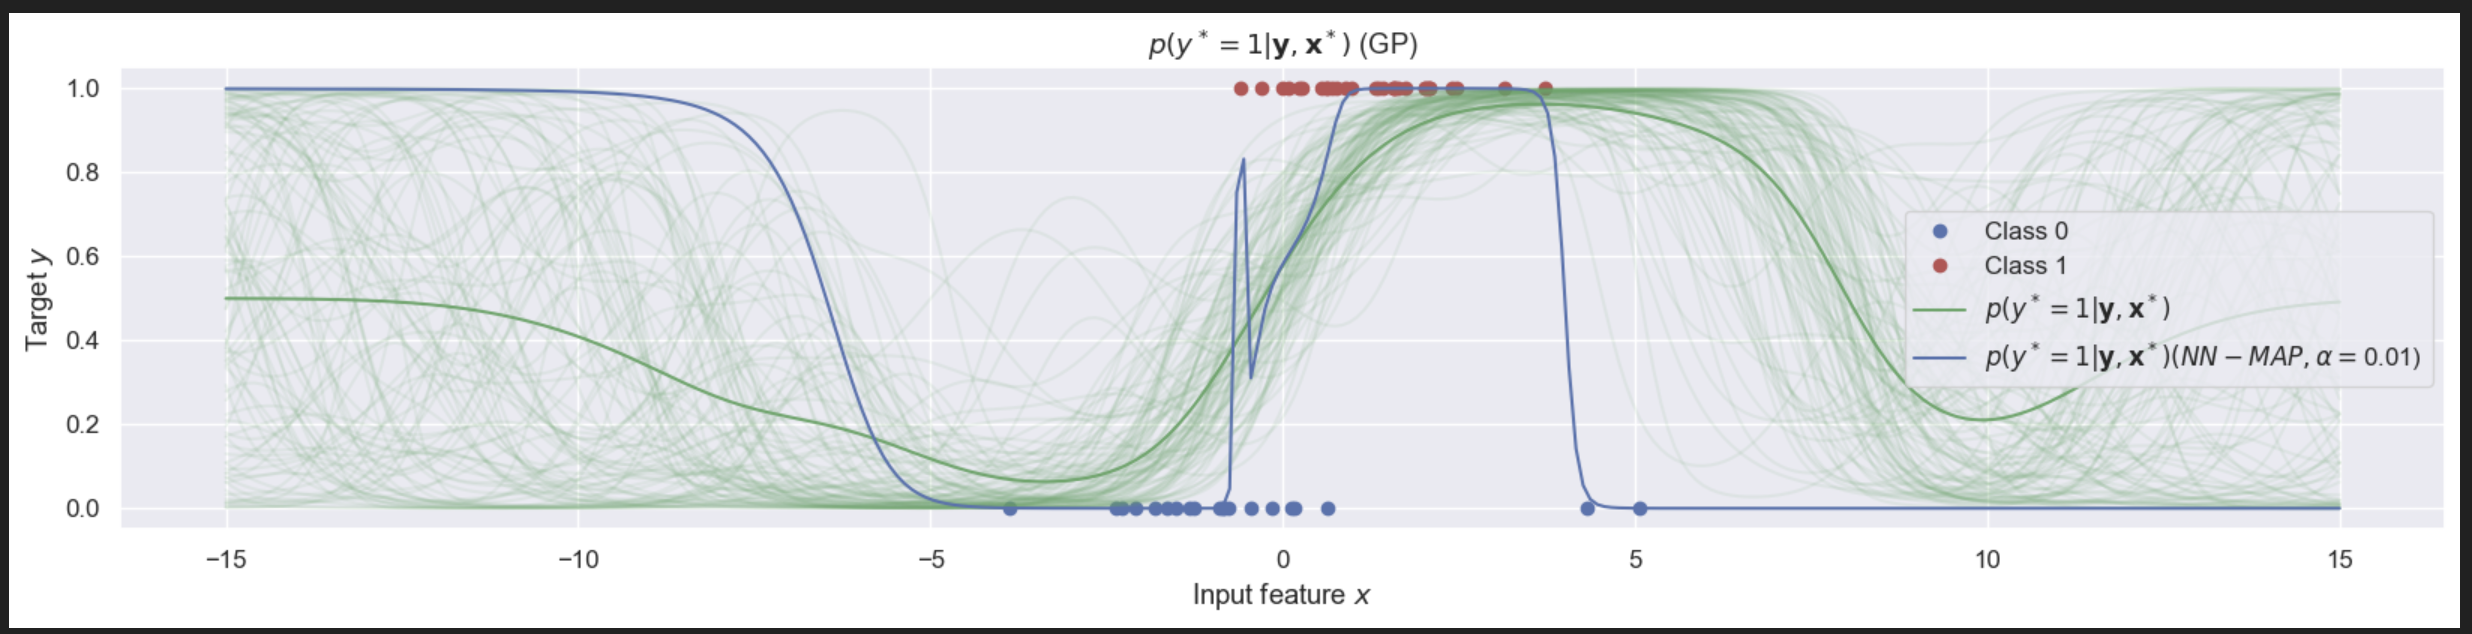
____
*Hint: Recall the relationship between Gaussian priors and regularization when using MAP estimates*

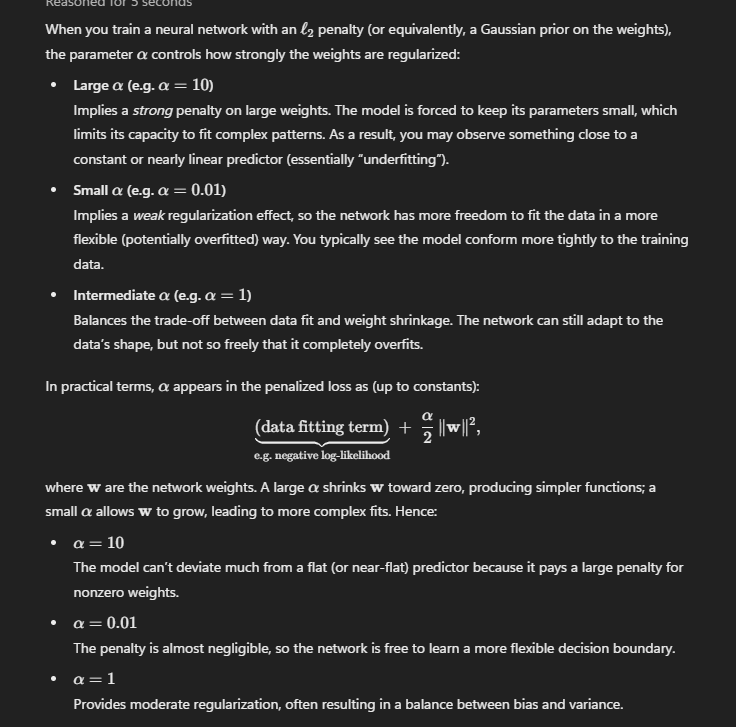

# Part 5:  Gaussian process classification for 2D data set

We will now use the MNIST data from week 4 to further study the properties of Gaussian process models.

The function in the cell below loads the MNIST data and projects the data to a 2-dimensional space using PCA as we did in week 4.

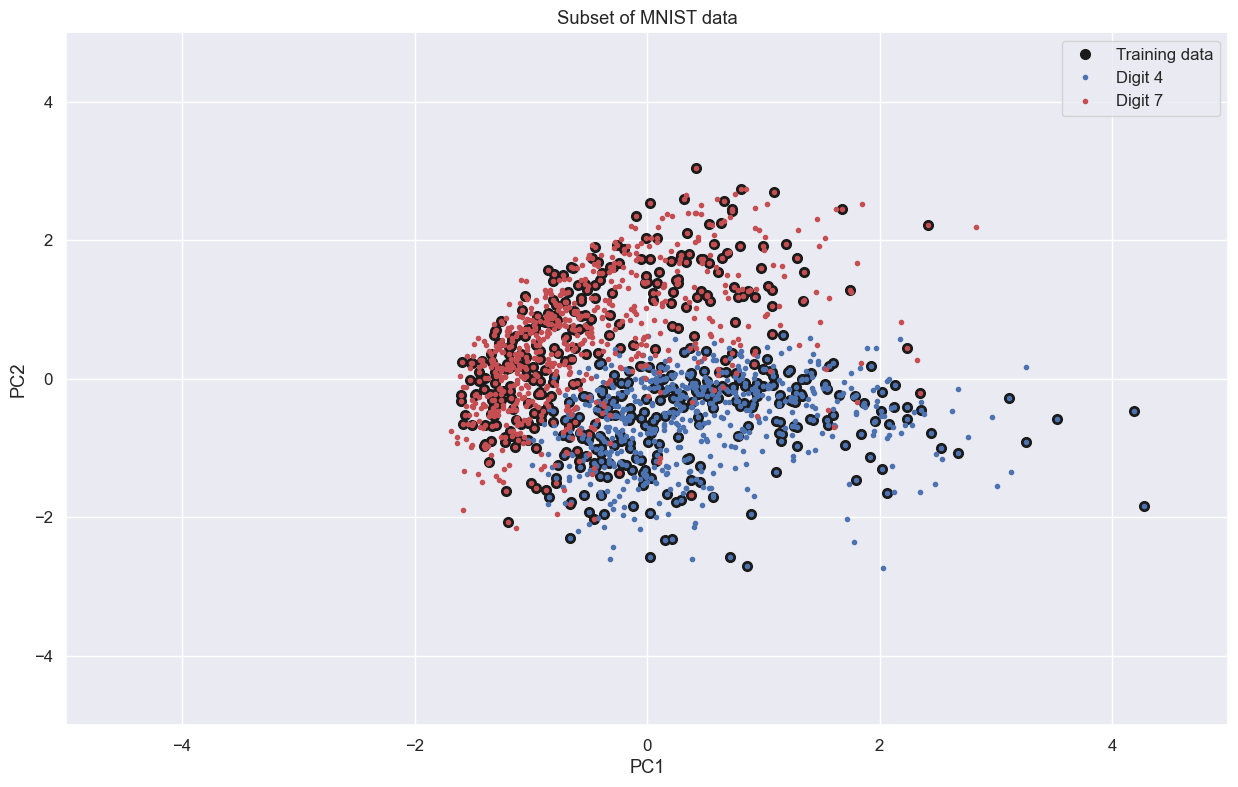

In [ ]:
# -------------------------------------------------------------------------
# Define the digits of interest: 4 and 7.
# This list determines which digit classes to extract from the MNIST dataset.
# -------------------------------------------------------------------------
digits = [4, 7]

# -------------------------------------------------------------------------
# Load a subset of the MNIST dataset.
# The function load_MNIST_subset loads the data from the file './mnist_subset.npz',
# filtering to include only the specified digits (4 and 7) and limiting the data
# to 500 examples (as specified by subset=500).
# It returns:
#   - Xtrain: Training input data (features)
#   - Xtest: Test input data (features)
#   - ytrain: Training labels
#   - ytest: Test labels
# -------------------------------------------------------------------------
Xtrain, Xtest, ytrain, ytest = load_MNIST_subset('./mnist_subset.npz', digits=digits, subset=500)

# -------------------------------------------------------------------------
# Reshape the label arrays so that each label is a column vector.
# This ensures that ytrain and ytest have dimensions [N x 1] rather than [N,].
# This is important for consistency in further processing and matrix operations.
# -------------------------------------------------------------------------
ytrain = ytrain[:, None]
ytest = ytest[:, None]

# -------------------------------------------------------------------------
# Concatenate training and test data along the first axis.
# This combines both sets of examples into a single dataset.
#   - X becomes an array of shape (N_total x D), where N_total = number of training examples + number of test examples.
#   - y becomes an array of shape (N_total x 1), containing the corresponding labels.
# -------------------------------------------------------------------------
X = jnp.concatenate((Xtrain, Xtest), axis=0)
y = jnp.concatenate((ytrain, ytest), axis=0)

# -------------------------------------------------------------------------
# Define a helper function to plot the data.
# This function plots the training data and the class-specific points.
#
# Parameters:
#   - ax: The matplotlib Axes object on which to plot.
#   - title: Title for the plot.
#   - xlim, ylim: Tuples that set the limits for the x-axis and y-axis.
#
# Inside the function:
#   - Training data (Xtrain) is plotted with black circles ('ko').
#   - Points corresponding to digit digits[0] (e.g., digit 4) are plotted as blue dots.
#   - Points corresponding to digit digits[1] (e.g., digit 7) are plotted as red dots.
#   - The plot limits, title, labels, and legend are all configured.
# -------------------------------------------------------------------------
def plot_data(ax, title="", xlim=(-5, 5), ylim=(-5, 5)):
    # Plot training data from Xtrain (using only the first two dimensions, assumed to be PC1 and PC2)
    ax.plot(Xtrain[:, 0], Xtrain[:, 1], 'ko', markersize=7, label='Training data')
    
    # Plot all points corresponding to the first digit (digits[0])
    ax.plot(X[y.ravel() == 0, 0], X[y.ravel() == 0, 1], 'b.', label='Digit %d' % digits[0])
    
    # Plot all points corresponding to the second digit (digits[1])
    ax.plot(X[y.ravel() == 1, 0], X[y.ravel() == 1, 1], 'r.', label='Digit %d' % digits[1])
    
    # Set the limits for x and y axes.
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    # Set the title, labels, and axis limits.
    ax.set(title=title, xlabel='PC1', ylabel='PC2')
    
    # Add a legend to the plot.
    ax.legend()

# -------------------------------------------------------------------------
# Create a figure and a single set of axes for plotting.
# The figure size is set to (15, 9) inches.
# -------------------------------------------------------------------------
fig, ax = plt.subplots(1, 1, figsize=(15, 9))

# Call the plot_data function to plot the subset of MNIST data on the axes.
# The plot will display the training data along with the data points for digits 4 and 7.
plot_data(ax, title='Subset of MNIST data')


Let's fit the Gaussian process

In [33]:
# Gaussian Process:
# -------------------------------------------------------------------------
# First, we create an instance of a stationary isotropic kernel using the
# squared exponential function. The squared exponential (or RBF) kernel is given by:
#
#   k(x, x') = κ exp( - (1 / (2ℓ²)) ||x - x'||² )
#
# where:
#   - κ (kappa) controls the overall magnitude (signal variance),
#   - ℓ (lengthscale) determines how quickly correlations decay with distance.
#
# In this case, we are using default hyperparameters κ = 1 and ℓ = 1.
kernel = StationaryIsotropicKernel(squared_exponential)

# Next, we instantiate the GaussianProcessClassification model using:
#   - Xtrain and ytrain: The training input points and their corresponding binary labels.
#   - BernoulliLikelihood: The likelihood function for binary classification, which models:
#         p(y=1 | f) = σ(f) = 1/(1 + exp(-f))
#   - kernel: The squared exponential kernel defined above.
#   - kappa=1. and lengthscale=1.: These hyperparameters set the behavior of the kernel.
#
# The GaussianProcessClassification class uses these inputs to construct a Gaussian process
# classifier, typically by first computing the kernel matrix for the training data and then
# applying a Laplace approximation to obtain a Gaussian approximation of the posterior:
#
#     p(f | X, y) ≈ N(m, S)
#
# where m is the MAP estimate (most likely latent function values) and S is the
# corresponding posterior covariance.
gpc = GaussianProcessClassification(Xtrain, ytrain, BernoulliLikelihood, kernel, kappa=1., lengthscale=1.)


Dimension of Sigma of Laplace (500, 500)
Dimension of mu of Laplace (500,)


... and plot the result

Training error:	0.08 (0.01)
Test error:	0.08 (0.01)


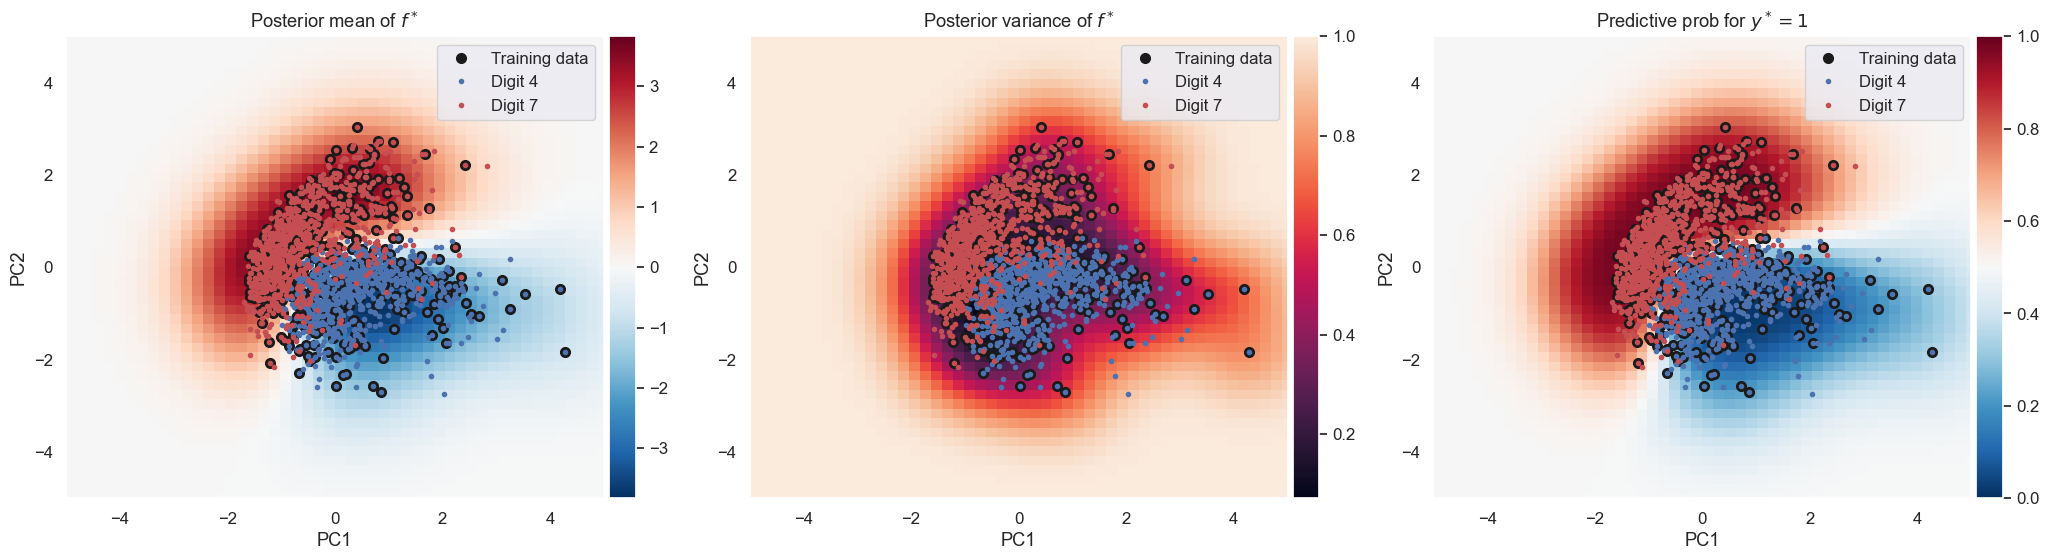

In [ ]:
# -------------------------------------------------------------------------
# Predictive Inference with the Gaussian Process Classifier
# -------------------------------------------------------------------------
# In a Gaussian process classification model, the predictive step involves two main tasks:
#
# 1. Computing the posterior predictive distribution for the latent function f* at new inputs:
#      p(f* | X*, X, y) ≈ N(μ*, Σ*),
#    where:
#      μ* = K_*X K⁻¹ m,
#      Σ* = K_** - K_*X K⁻¹ K_X*.
#
# 2. Mapping the latent predictions through the likelihood’s link function (e.g., sigmoid)
#    to obtain predictive probabilities for the class label:
#      p(y*=1 | X*, X, y) = ∫ σ(f*) p(f* | X*, X, y) df*.
#
# Here, we first compute predictive probabilities for the training and test data,
# then threshold them at 0.5 to obtain class predictions.
# -------------------------------------------------------------------------

# Predict the posterior predictive probabilities for the training inputs.
# p_train = p(y=1 | X_train, X, y)
p_train = gpc.predict_y(Xtrain)
# Similarly, compute predictions for the test inputs.
p_test = gpc.predict_y(Xtest)

# Make binary predictions by thresholding the predictive probabilities at 0.5.
# If p > 0.5, we predict class 1; otherwise, class 0.
ytrain_hat = 1.0 * (p_train > 0.5)
ytest_hat  = 1.0 * (p_test  > 0.5)

# Compute and print the classification error (mean and standard error).
# The function compute_err computes the error between the predicted and true labels.
print('Training error:\t%3.2f (%3.2f)' % compute_err(ytrain_hat.ravel(), ytrain.ravel()))
print('Test error:\t%3.2f (%3.2f)' % compute_err(ytest_hat.ravel(), ytest.ravel()))

# -------------------------------------------------------------------------
# Evaluate the predictive distributions over a grid for visualization.
#
# We create a grid in the input space to visualize:
#   (i) the posterior mean of the latent function f*,
#  (ii) the posterior variance (diagonal of Σ*),
# (iii) the predictive probabilities for y*=1.
#
# The functions eval_density_grid evaluate the corresponding function on a grid with P points.
# -------------------------------------------------------------------------
# Evaluate the predictive mean μ* for the latent function f*.
# That is, for each point x in the grid, compute μ*(x) = [gpc.predict_f(x)[0]].
x_grid, posterior_y_gpc_eval_mu = eval_density_grid(lambda x: gpc.predict_f(x)[0], P=50)

# Evaluate the predictive variance for f* by extracting the diagonal of the predictive covariance Σ*.
x_grid, posterior_y_gpc_eval_var = eval_density_grid(lambda x: jnp.diag(gpc.predict_f(x)[1]), P=50)

# Evaluate the predictive probability for y*=1 by using gpc.predict_y.
# This gives p(x) = p(y*=1 | x, X, y) for each point x in the grid.
x_grid, posterior1_gpc_eval = eval_density_grid(gpc.predict_y, P=50, a=-5, b=5)

# -------------------------------------------------------------------------
# Plot the results: Posterior mean, variance, and predictive probabilities.
# -------------------------------------------------------------------------
fig, ax = plt.subplots(1, 3, figsize=(25, 6))

# --- Plot 1: Posterior Mean of f* ---
#
# Use pcolormesh to create a color plot of the posterior mean μ* over the grid.
# The color mapping is set using the RdBu_r colormap and centered with colors.CenteredNorm().
im = ax[0].pcolormesh(x_grid, x_grid, posterior_y_gpc_eval_mu, cmap=plt.cm.RdBu_r,
                      norm=colors.CenteredNorm(), shading='auto')
# Overlay the training data on the plot.
plot_data(ax[0], title="Posterior mean of $f^*$")
# Add a colorbar to the first subplot for reference.
add_colorbar(im, fig, ax[0])

# --- Plot 2: Posterior Variance of f* ---
#
# Here, we visualize the uncertainty in the latent function by plotting the posterior variance.
im = ax[1].pcolormesh(x_grid, x_grid, posterior_y_gpc_eval_var, shading='auto')
plot_data(ax[1], title="Posterior variance of $f^*$")
add_colorbar(im, fig, ax[1])

# --- Plot 3: Predictive Probability for y*=1 ---
#
# This plot shows the probability of class 1 (digit 7, for instance) for new inputs.
# We use a colormap that maps probabilities between 0 and 1.
im = ax[2].pcolormesh(x_grid, x_grid, posterior1_gpc_eval, cmap=plt.cm.RdBu_r,
                      shading='auto', clim=(0, 1))
plot_data(ax[2], title="Predictive prob for $y^* = 1$")
add_colorbar(im, fig, ax[2])

# -------------------------------------------------------------------------
# Why use the Sigmoid in the Predictive Mapping?
#
# The latent function f* produced by the Gaussian process is unbounded (f* ∈ ℝ).
# For binary classification, we need to map these values to probabilities in [0,1].
# The sigmoid function:
#
#       σ(f) = 1 / (1 + exp(-f))
#
# converts any real-valued input to a value between 0 and 1, making it a natural
# choice for the link function in binary classification. In our model,
# applying sigmoid to f_samples yields predictive samples for p(y*=1 | X*, X, y).
# -------------------------------------------------------------------------


**Task 5.1**: Explain what you see in the 3 panels - explain the difference between the two distributions $p(f^*|\mathbf{y})$ and $p(y^*|\mathbf{y})$ [**Discussion question**]

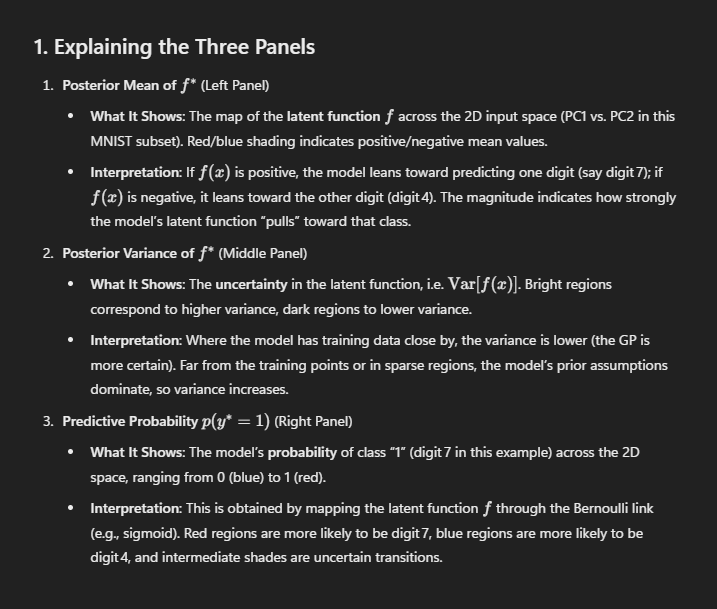

**Task 5.2**: What does the values of mean $\mathbf{m}$ in the Laplace approximation $q(\mathbf{f}) = \mathcal{N}(\mathbf{f}|\mathbf{m}, \mathbf{S})$ represent and how does it relate to the figures? [**Discussion question**]

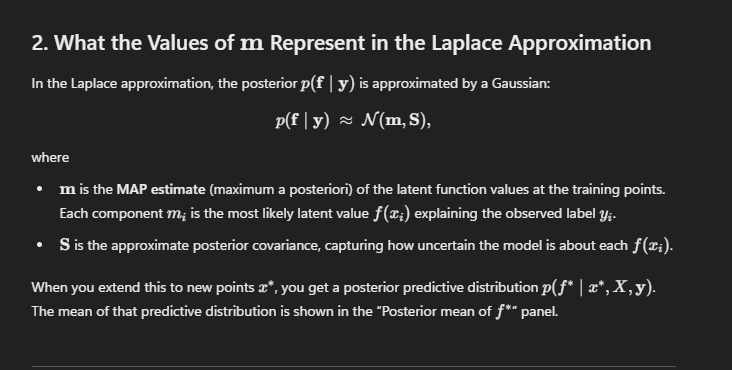

**Task 5.3**: Comment on the uncertainties within the support of the data and outside the data. Compare with the equivalent plots for the NN below [**Discussion question**]

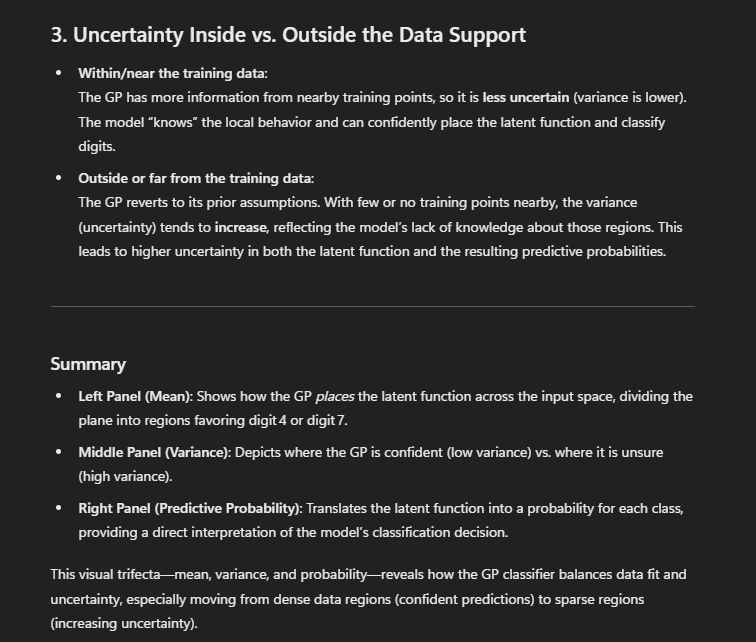

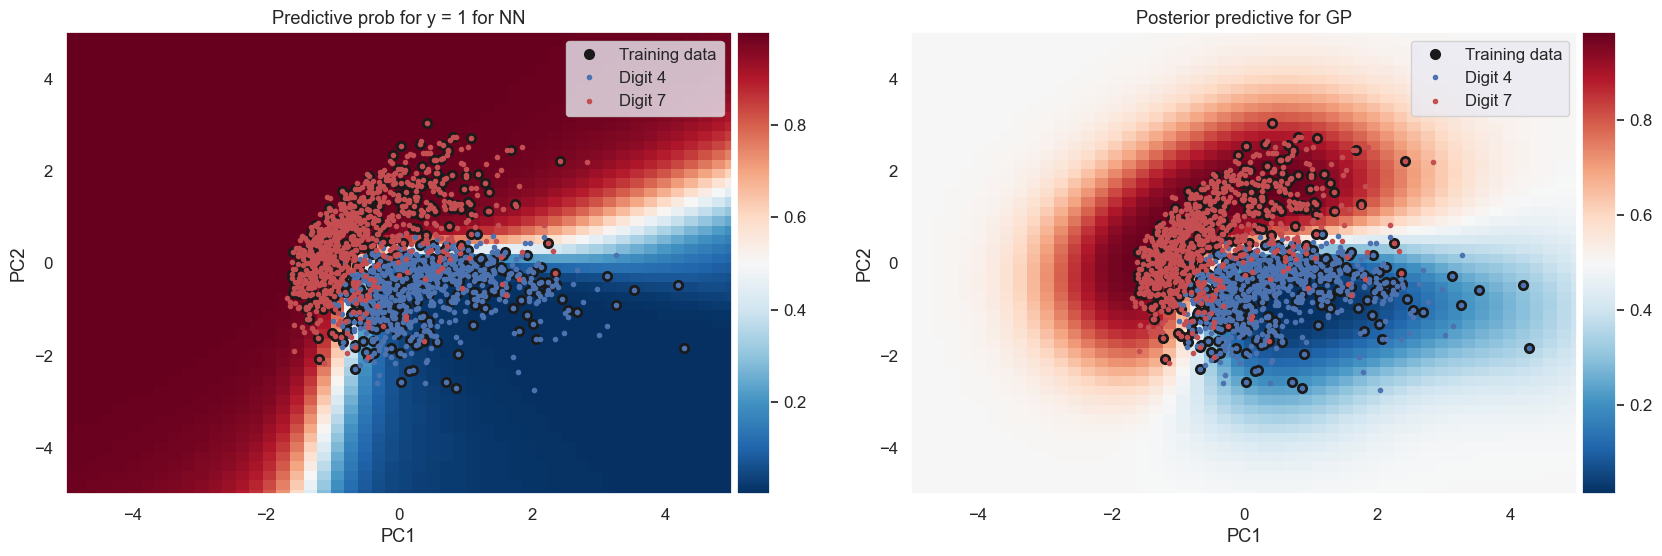

In [ ]:
# -------------------------------------------------------------------------
# Instantiate the Neural Network using MAP estimation.
# -------------------------------------------------------------------------
# Here, NeuralNetworkMAP is initialized with:
#   - Xtrain and ytrain: the training data (inputs and binary labels).
#   - Architecture: [2, 20, 20, 1] specifies:
#         * 2 input neurons (so each input is 2-dimensional),
#         * 2 hidden layers with 20 neurons each,
#         * 1 output neuron.
#   - alpha = 1.: This controls the strength of the L2 regularization (or prior variance)
#         in the MAP estimation; the loss function includes a term of the form:
#
#             (alpha/2)*||w||^2 + (data term)
#
#   - likelihood = BernoulliLikelihood: the network is used for binary classification,
#         so the output is interpreted through a sigmoid function.
#
# The network is trained by maximizing the posterior (or equivalently minimizing the negative log-posterior)
# to obtain a MAP estimate of its parameters.
nn = NeuralNetworkMAP(Xtrain, ytrain, [2, 20, 20, 1], alpha=1., likelihood=BernoulliLikelihood)

# -------------------------------------------------------------------------
# Evaluate the predictive probability of the Neural Network on a grid.
# ----------------------------------------# over a grid in the input space. The lambda function maps any input x (from the grid) to:
---------------------------------
# We use eval_density_grid to evaluate the function (in this case, the predictive probability)
#
#    sigmoid( nn.predict(x) )
#
# where:
#    nn.predict(x) gives the network's output (logits) at x.
#    sigmoid(z) = 1/(1 + exp(-z)) maps logits to probabilities.
#
# The grid has P=50 points along each dimension, covering the range from a=-5 to b=5.
x_grid, posterior1_nn_eval = eval_density_grid(lambda x: sigmoid(nn.predict(x)), P=50, a=-5, b=5)

# -------------------------------------------------------------------------
# Plot the Neural Network and Gaussian Process predictions for comparison.
# -------------------------------------------------------------------------
# Create a figure with 2 subplots side-by-side.
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# --------------------------
# Plot 1: Neural Network Predictive Probability
# --------------------------
# Use pcolormesh to visualize the predictive probabilities (for y=1) evaluated on the grid.
# The colormap RdBu_r is used to show variations in probability.
im = ax[0].pcolormesh(x_grid, x_grid, posterior1_nn_eval, cmap=plt.cm.RdBu_r, shading='auto')
# Overlay the training data to visualize where the network was trained.
plot_data(ax[0], title='Predictive prob for $y = 1$ for NN')
# Add a colorbar to indicate the mapping from color to probability values.
add_colorbar(im, fig, ax[0])

# --------------------------
# Plot 2: Gaussian Process Posterior Predictive Probability
# --------------------------
# posterior1_gpc_eval was previously computed from the GP model.
# It represents the GP's predictive probability for y=1 over the same grid.
im = ax[1].pcolormesh(x_grid, x_grid, posterior1_gpc_eval, cmap=plt.cm.RdBu_r, shading='auto')
plot_data(ax[1], title='Posterior predictive for GP')
add_colorbar(im, fig, ax[1])

# -------------------------------------------------------------------------
# Additional Explanation:
#
# For the neural network (NN-MAP):
#   - The network outputs a real number z = nn.predict(x).
#   - The predictive probability is obtained as:
#
#         p(y=1|x) = sigmoid(z) = 1/(1 + exp(-z))
#
#     This maps the unconstrained output z into a probability in [0, 1].
#
# For the Gaussian Process (GP):
#   - The GP model computes a predictive distribution for the latent function f* at new input x:
#
#         f* | x, X, y ~ N(μ*, Σ*)
#
#   - The predictive probability for y=1 is then given by passing f* through a link function,
#     such as a probit or sigmoid. In our visualization, posterior1_gpc_eval represents the GP’s
#     predictive probability for y=1 computed over the grid.
#
# In these plots, you can compare how the NN-MAP and GP models behave in different regions of
# the input space. Typically, the GP's predictive probabilities will reflect uncertainty
# (e.g., reverting to a prior probability in regions far from training data), while the NN-MAP
# prediction may be more "confident" even when extrapolating.
# -------------------------------------------------------------------------
